# 📷 Trabajo 03 — Parte 0: Descarga de la data y Estructura

In [1]:
# Setup: imports y rutas
from pathlib import Path
from typing import List, Tuple, Union, Optional
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict, Counter
from skimage.feature import hog
from skimage import measure
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn
import cv2
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [2]:
ROOT = Path('.').resolve()
DATA_RAW = ROOT / 'data' / 'raw' / 'chest_xray'   # <-- aquí debe estar train/ val/ test/
DATA_RAW.mkdir(parents=True, exist_ok=True)

DATA_PROCESSED = ROOT / 'data' / 'processed'

OUTPUT_FIGS = ROOT / 'resultados' / 'exploracion' / 'figures'
OUTPUT_TABLES = ROOT / 'resultados' / 'exploracion' / 'tables'

OUTPUT_FIGS_FT = ROOT / 'resultados' / 'descriptores_forma' / 'figures'
OUTPUT_TABLES_FT = ROOT / 'resultados' / 'descriptores_forma' / 'tables'

OUTPUT_FIGS_TEXTURE = ROOT / "resultados" / "descriptores_textura" / "figures"
OUTPUT_TABLES_TEXTURE = ROOT / "resultados" / "descriptores_textura" / "tables"

OUTPUT_MODELS_FIGS = ROOT / 'resultados' / 'models' / "figures"
OUTPUT_MODELS_TABLES = ROOT / 'resultados' / 'models' / "tables"


# Imagen por si no está el dataset completo
EXAMPLE_IMG = Path(ROOT / 'data/person1946_bacteria_4875.jpeg')

In [3]:
# Crear carpetas de salida si no existen
for p in [
    DATA_PROCESSED, OUTPUT_FIGS, OUTPUT_TABLES,
    OUTPUT_FIGS_FT, OUTPUT_TABLES_FT,
    OUTPUT_FIGS_TEXTURE, OUTPUT_TABLES_TEXTURE, OUTPUT_MODELS_FIGS, OUTPUT_MODELS_TABLES
]:
    p.mkdir(parents=True, exist_ok=True)

In [4]:
print("DATA_RAW exists?", DATA_RAW.exists())
print("DATA_PROCESSED exists?", DATA_PROCESSED.exists())
print("OUTPUT_FIGS exists?", OUTPUT_FIGS.exists())
print("OUTPUT_TABLES exists?", OUTPUT_TABLES.exists())

DATA_RAW exists? True
DATA_PROCESSED exists? True
OUTPUT_FIGS exists? True
OUTPUT_TABLES exists? True


In [5]:
# Carpetas esperadas en DATA_RAW
DESIRED = {"train", "val", "test"}

# Advertencia: 

A continuacion se van a descargar los archivos desde el directorio original y despues se traeran a la carpeta de data los folder necesarios (train, tes, val). Para que despues eliminen la descarga del directorio original ( El codigo devuelve el nombre del directorio).

In [6]:
# Descargar dataset usando kagglehub si está disponible
downloaded = None
try:
    import kagglehub
    print("Usando kagglehub...")
    downloaded = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
except Exception as e:
    print("kagglehub no disponible o falló:", e)
    downloaded = None

c:\Users\USER\anaconda3\envs\VisionComputerpy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Usando kagglehub...


In [7]:
from src.extract_selected import extract_selected_from_zip, extract_selected_from_tar, move_selected_from_dir

In [8]:
if downloaded:
    dpath = Path(downloaded)
    if dpath.is_file():
        suffix = dpath.suffix.lower()
        if suffix == ".zip":
            extract_selected_from_zip(dpath, DATA_RAW)
        elif suffix in {".tgz", ".gz", ".tar", ".bz2", ".xz"} or dpath.name.endswith((".tar.gz", ".tar.bz2")):
            extract_selected_from_tar(dpath, DATA_RAW)
        else:
            print("Archivo desconocido:", dpath)
    elif dpath.is_dir():
        move_selected_from_dir(dpath, DATA_RAW)
    else:
        print("Respuesta inesperada:", dpath)
else:
    print("No se pudo descargar el dataset automáticamente. Como alternativa, usa:\n\n"
          "kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p ./tmp_kaggle_dl --force\n"
          "y luego ejecuta el bloque de extracción anterior sobre el zip resultante.")

print("EXAMPLE_IMG exists?", EXAMPLE_IMG.exists())

Movida C:\Users\USER\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\train -> C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\data\raw\chest_xray\train
Movida C:\Users\USER\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\val -> C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\data\raw\chest_xray\val
Movida C:\Users\USER\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\test -> C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\data\raw\chest_xray\test
EXAMPLE_IMG exists? True


# 📷 Trabajo 03 — Parte 1: Análisis Exploratorio y Preprocesamiento

-----------------------------------------------------------------------------------------------

## Cargar y visualizar ejemplos de ambas clases (o imagen ejemplo si no hay dataset)

In [9]:
# Función para listar imágenes organizadas por split y clase
def list_images_by_split_and_class(data_root):
    """
    Devuelve un dict: { 'train': {'NORMAL': [Path,...], 'PNEUMONIA': [...]}, 'val': {...}, 'test': {...} }
    """
    splits = ['train','val','test']
    result = {}
    for s in splits:
        sdir = data_root / s
        if not sdir.exists():
            continue
        classes = {}
        for cls in sorted([p for p in sdir.iterdir() if p.is_dir()]):
            # aceptar extensiones comunes
            imgs = []
            for ext in ('*.png','*.jpg','*.jpeg','*.tif','*.bmp'):
                imgs.extend(list((cls).rglob(ext)))
            classes[cls.name] = sorted(imgs)
        result[s] = classes
    return result

classes = list_images_by_split_and_class(DATA_RAW)
if not classes:
    print("No se encontraron splits train/val/test en", DATA_RAW)
else:
    for split, mapping in classes.items():
        print(f"Split: {split}")
        for cls_name, files in mapping.items():
            print(f"  {cls_name}: {len(files)} imágenes")


Split: train
  NORMAL: 1341 imágenes
  PNEUMONIA: 3875 imágenes
Split: val
  NORMAL: 8 imágenes
  PNEUMONIA: 8 imágenes
Split: test
  NORMAL: 234 imágenes
  PNEUMONIA: 390 imágenes


## Distribución de clases y tamaños de imágenes

--- Split: train ---


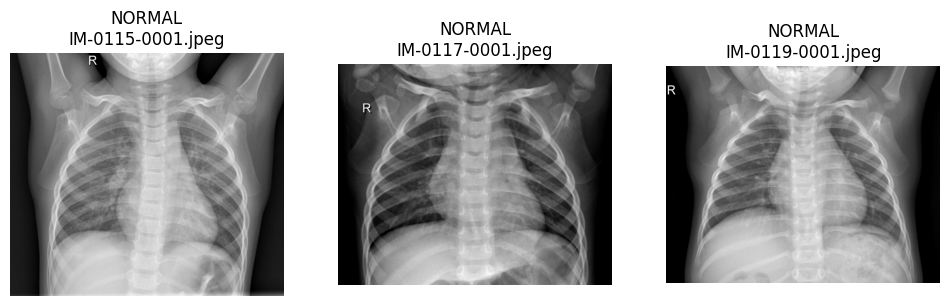

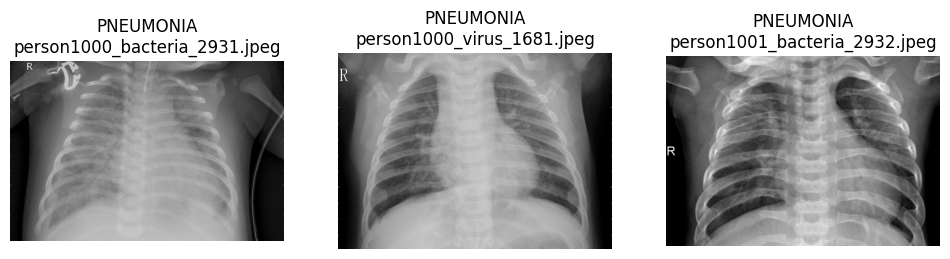

--- Split: val ---


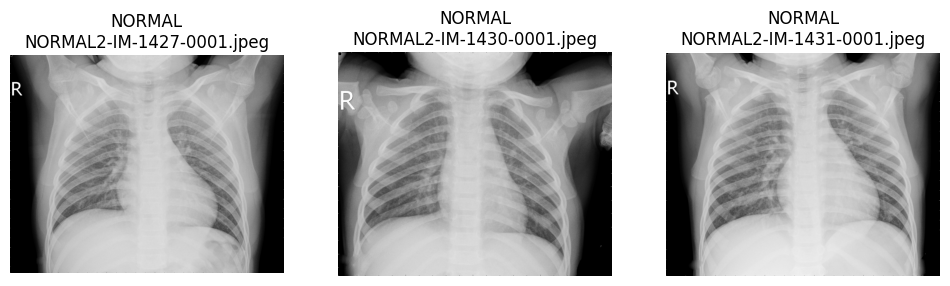

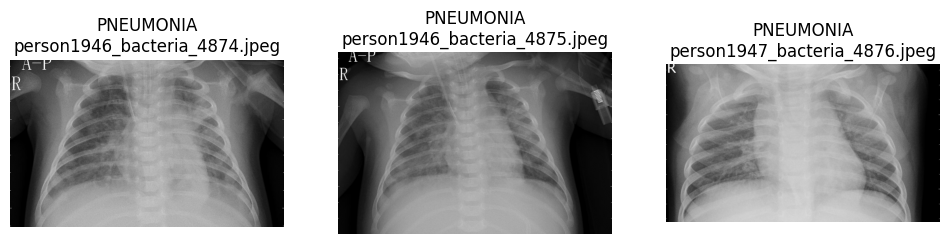

--- Split: test ---


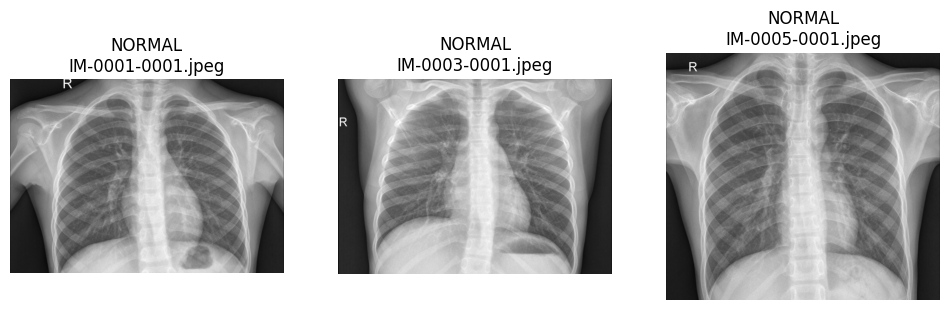

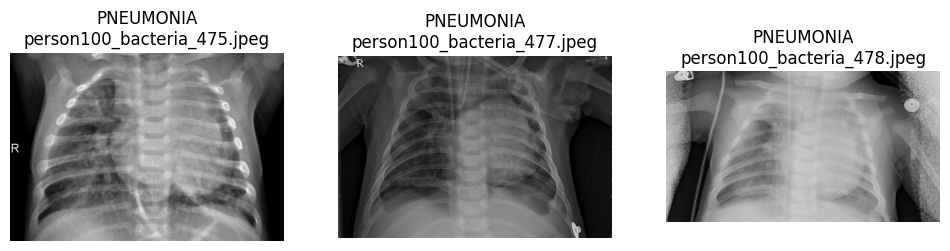

In [10]:
# Mostrar hasta 3 ejemplos por clase por split (siempre que existan)
def show_examples(classes_dict, max_per_class=3, figsize=(12,8)):
    for split, mapping in classes_dict.items():
        if not mapping:
            continue
        print(f"--- Split: {split} ---")
        for cls_name, files in mapping.items():
            n = min(max_per_class, len(files))
            if n == 0:
                print(f"{cls_name}: 0 imágenes")
                continue
            fig, axs = plt.subplots(1, n, figsize=(4*n,4))
            if n == 1:
                axs = [axs]
            for ax, fp in zip(axs, files[:n]):
                try:
                    img = Image.open(fp)
                    ax.imshow(img.convert('L'), cmap='gray')
                    ax.set_title(f"{cls_name}\n{fp.name}")
                    ax.axis('off')
                except Exception as e:
                    ax.set_title("Error")
            plt.show()

if classes:
    show_examples(classes)
else:
    # dataset ausente: mostrar la imagen de ejemplo del usuario
    if EXAMPLE_IMG.exists():
        img = Image.open(EXAMPLE_IMG)
        plt.figure(figsize=(5,5))
        plt.imshow(img.convert('L'), cmap='gray')
        plt.title('Imagen de ejemplo (usuario)')
        plt.axis('off')
        plt.show()
    else:
        print("No hay imagen de ejemplo disponible.")


Conteo por split y clase:


split        cls  n_images
0   test     NORMAL       234
1   test  PNEUMONIA       390
2  train     NORMAL      1341
3  train  PNEUMONIA      3875
4    val     NORMAL         8
5    val  PNEUMONIA         8

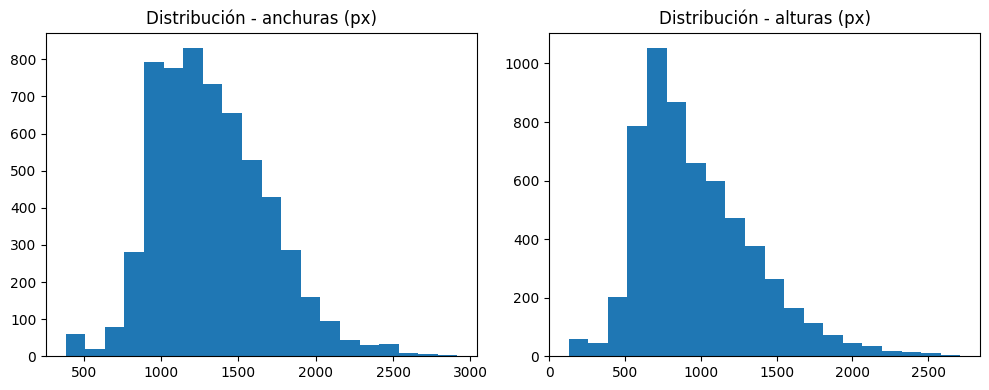

Guardado:  C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\exploracion\tables\class_counts_by_split.csv


In [11]:
# Conteo y tamaños por split y clase
size_counter = Counter()
class_counts = defaultdict(int)

if classes:
    for split, mapping in classes.items():
        for cls_name, files in mapping.items():
            class_counts[f"{split}/{cls_name}"] += len(files)
            for fp in files:
                try:
                    with Image.open(fp) as im:
                        size_counter[im.size] += 1
                except Exception:
                    pass

# Mostrar tabla de conteos
df_counts = pd.Series(class_counts).sort_index().rename("n_images").reset_index()
df_counts[['split','cls']] = df_counts['index'].str.split('/', expand=True)
df_counts = df_counts[['split','cls','n_images']]
print("Conteo por split y clase:")
display(df_counts)

# Histograma de tamaños (anchura x altura)
if size_counter:
    widths = []; heights = []
    for (w,h), cnt in size_counter.items():
        widths += [w]*cnt
        heights += [h]*cnt
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.hist(widths, bins=20)
    plt.title('Distribución - anchuras (px)')
    plt.subplot(1,2,2)
    plt.hist(heights, bins=20)
    plt.title('Distribución - alturas (px)')
    plt.tight_layout()
    plt.show()

# Guardar tabla de conteos
df_counts.to_csv(OUTPUT_TABLES / 'class_counts_by_split.csv', index=False)
print("Guardado: ", OUTPUT_TABLES / 'class_counts_by_split.csv')


## Pipeline de preprocesamiento: normalización de tamaño y CLAHE (ecualización adaptativa)

In [12]:
from src.parte_1.preprocess_image import preprocess_image_save

In [13]:
# Pipeline: leer cada imagen, convertir a grayscale, aplicar CLAHE, redimensionar y guardar en data/processed/{split}/{class}/

# Ejecutar pipeline sobre todo el dataset si está presente
processed_records = []
if classes:
    for split, mapping in classes.items():
        for cls_name, files in mapping.items():
            for fp in tqdm(files, desc=f"Procesando {split}/{cls_name}", unit="img"):
                rel_out = DATA_PROCESSED / split / cls_name / fp.name
                success = preprocess_image_save(fp, rel_out, size=(224,224), apply_clahe=True)
                processed_records.append({
                    'original_path': str(fp),
                    'processed_path': str(rel_out) if success else '',
                    'split': split,
                    'class': cls_name,
                    'processed': success
                })
else:
    # dataset no encontrado -> procesar la imagen de ejemplo (si existe)
    if EXAMPLE_IMG.exists():
        outp = DATA_PROCESSED / 'demo' / EXAMPLE_IMG.name
        ok = preprocess_image_save(EXAMPLE_IMG, outp, size=(224,224), apply_clahe=True)
        processed_records.append({
            'original_path': str(EXAMPLE_IMG),
            'processed_path': str(outp) if ok else '',
            'split': 'demo',
            'class': 'example',
            'processed': ok
        })
    else:
        print("No hay datos para procesar.")

# Guardar resumen en CSV
df_processed = pd.DataFrame(processed_records)
df_processed.to_csv(OUTPUT_TABLES / 'part1_processed_files.csv', index=False)
print("Resumen de procesamiento guardado en:", OUTPUT_TABLES / 'part1_processed_files.csv')
display(df_processed.head())


Procesando test/PNEUMONIA: 100%|██████████| 390/390 [00:06<00:00, 57.69img/s]


Resumen de procesamiento guardado en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\exploracion\tables\part1_processed_files.csv


original_path  \
0  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...   
1  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...   
2  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...   
3  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...   
4  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...   

                                      processed_path  split   class  processed  
0  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL       True  
1  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL       True  
2  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL       True  
3  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL       True  
4  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL       True

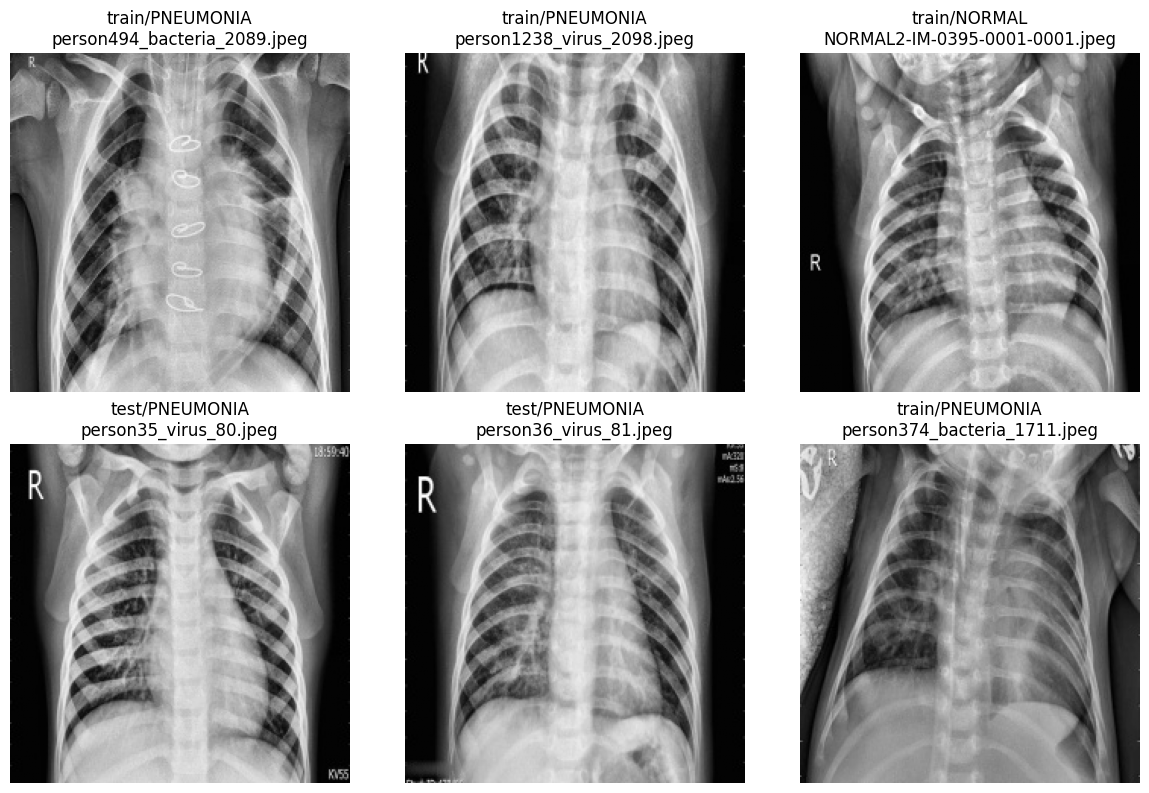

split      class  n_processed
0   test     NORMAL          234
1   test  PNEUMONIA          390
2  train     NORMAL         1341
3  train  PNEUMONIA         3875
4    val     NORMAL            8
5    val  PNEUMONIA            8

Guardado: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\exploracion\tables\processed_counts_by_split.csv


In [14]:
# Comprobaciones: mostrar algunos ejemplos procesados y la nueva distribución por split/class
if not df_processed.empty:
    # Mostrar 3 procesadas (aleatorias)
    sample_proc = df_processed[df_processed['processed']].sample(min(6, len(df_processed)), random_state=0)
    n = len(sample_proc)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axs = axs.flatten() if n>1 else [axs]
    for ax, (_, r) in zip(axs, sample_proc.iterrows()):
        try:
            im = Image.open(r['processed_path'])
            ax.imshow(im.convert('L'), cmap='gray')
            ax.set_title(f"{r['split']}/{r['class']}\n{Path(r['processed_path']).name}")
            ax.axis('off')
        except Exception as e:
            ax.set_title("Error")
    plt.tight_layout()
    plt.show()

    # Nueva tabla de conteos en processed
    proc_counts = df_processed[df_processed['processed']].groupby(['split','class']).size().reset_index(name='n_processed')
    display(proc_counts)
    proc_counts.to_csv(OUTPUT_TABLES / 'processed_counts_by_split.csv', index=False)
    print("Guardado:", OUTPUT_TABLES / 'processed_counts_by_split.csv')
else:
    print("No hay archivos procesados para mostrar.")


## Antes/Despues

In [15]:
from src.parte_1.before_after import shannon_entropy, local_std_img

In [16]:
# Parámetros
N_SAMPLE = 200             # número de pares a evaluar (ajusta si dataset grande)
KSIZE_LOCAL_STD = 31       # ventana para desviación local
FIG_DIR = Path(OUTPUT_FIGS)


# Seleccionar pares procesados
pairs = df_processed[df_processed['processed'] & df_processed['processed_path'].astype(bool)].copy()
if pairs.empty:
    raise RuntimeError("df_processed vacío o sin filas procesadas. Ejecuta el pipeline primero.")

pairs = pairs.sample(n=min(N_SAMPLE, len(pairs)), random_state=0).reset_index(drop=True)

In [17]:
# Recolectar métricas
rows = []
for i, r in tqdm(pairs.iterrows(), total=len(pairs), desc="Calculando métricas"):
    try:
        orig_p = Path(r['original_path'])
        proc_p = Path(r['processed_path'])
        orig = cv2.imread(str(orig_p), cv2.IMREAD_UNCHANGED)
        proc = cv2.imread(str(proc_p), cv2.IMREAD_UNCHANGED)

        if orig is None or proc is None:
            continue

        # convertir a grayscale si es RGB
        if orig.ndim == 3:
            orig_gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
        else:
            orig_gray = orig.copy()
        if proc.ndim == 3:
            proc_gray = cv2.cvtColor(proc, cv2.COLOR_BGR2GRAY)
        else:
            proc_gray = proc.copy()

        # asegurar tipo uint8
        if orig_gray.dtype != np.uint8:
            o = cv2.normalize(orig_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            o = orig_gray
        if proc_gray.dtype != np.uint8:
            p = cv2.normalize(proc_gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            p = proc_gray

        # métricas globales
        mean_o, std_o = float(o.mean()), float(o.std())
        mean_p, std_p = float(p.mean()), float(p.std())

        # entropía
        ent_o = float(shannon_entropy(o))
        ent_p = float(shannon_entropy(p))

        # porcentaje de píxeles saturados (0 o 255)
        pct0_o = (o == 0).mean()
        pct255_o = (o == 255).mean()
        pct0_p = (p == 0).mean()
        pct255_p = (p == 255).mean()

        # desviación local media
        local_o = local_std_img(o, ksize=KSIZE_LOCAL_STD)
        local_p = local_std_img(p, ksize=KSIZE_LOCAL_STD)
        local_o_mean = float(local_o.mean())
        local_p_mean = float(local_p.mean())

        rows.append({
            'original_path': str(orig_p),
            'processed_path': str(proc_p),
            'split': r.get('split', ''),
            'class': r.get('class', ''),
            'mean_o': mean_o, 'std_o': std_o, 'entropy_o': ent_o,
            'pct0_o': pct0_o, 'pct255_o': pct255_o, 'localstd_o': local_o_mean,
            'mean_p': mean_p, 'std_p': std_p, 'entropy_p': ent_p,
            'pct0_p': pct0_p, 'pct255_p': pct255_p, 'localstd_p': local_p_mean
        })
    except Exception as e:
        # no romper la ejecución por una imagen corrupta
        continue

Calculando métricas: 100%|██████████| 200/200 [00:21<00:00,  9.16it/s]


Guardado: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\exploracion\tables\before_after_stats.csv


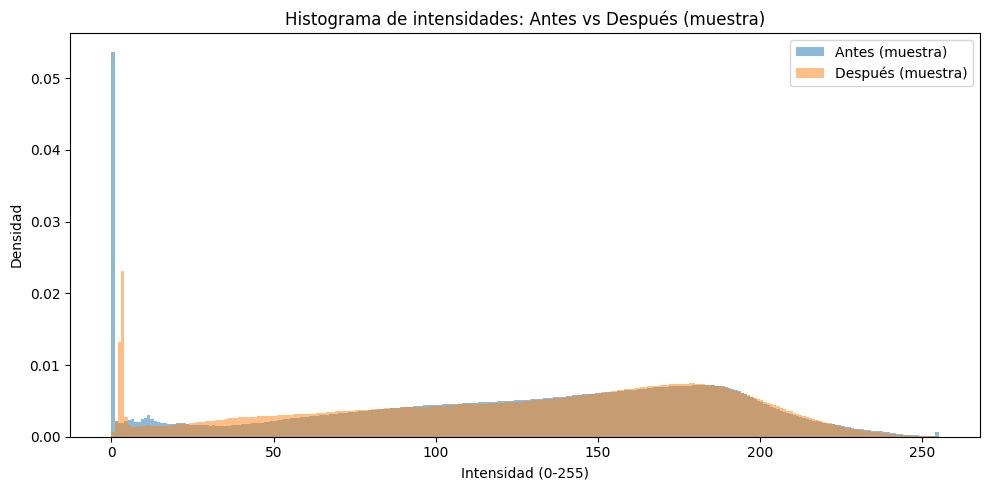

C:\Users\USER\AppData\Local\Temp\ipykernel_20156\1137014391.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_ent, labels=['Entropy antes','Entropy después'])
C:\Users\USER\AppData\Local\Temp\ipykernel_20156\1137014391.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_loc, labels=['LocalStd antes','LocalStd después'])


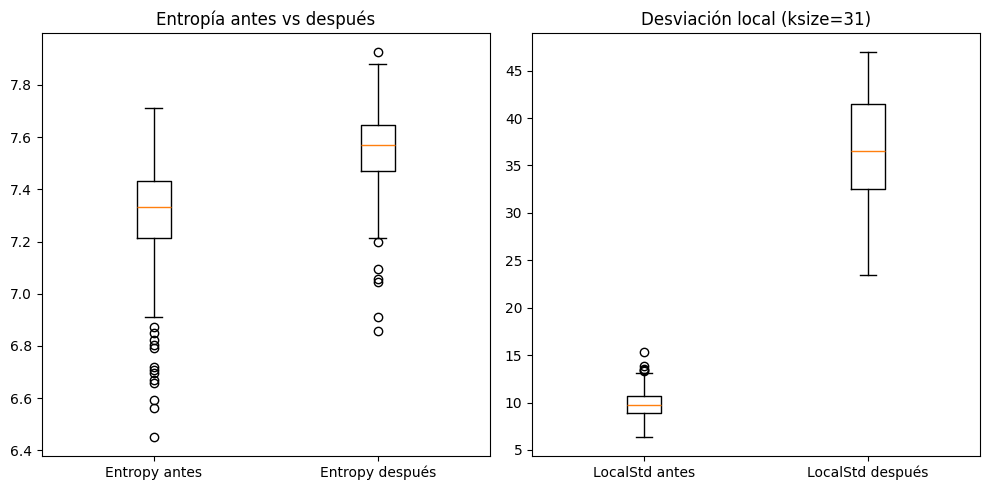

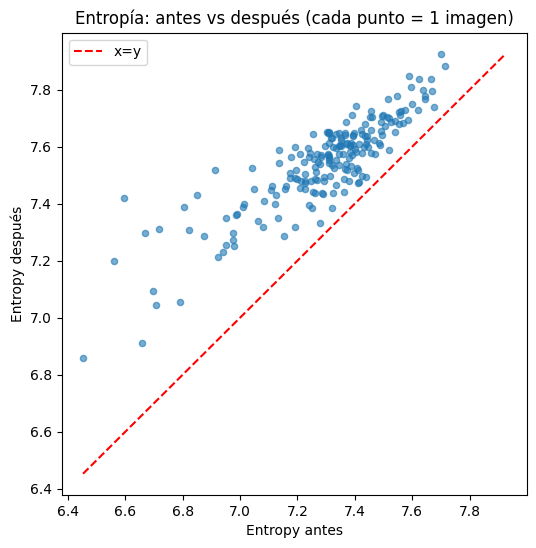

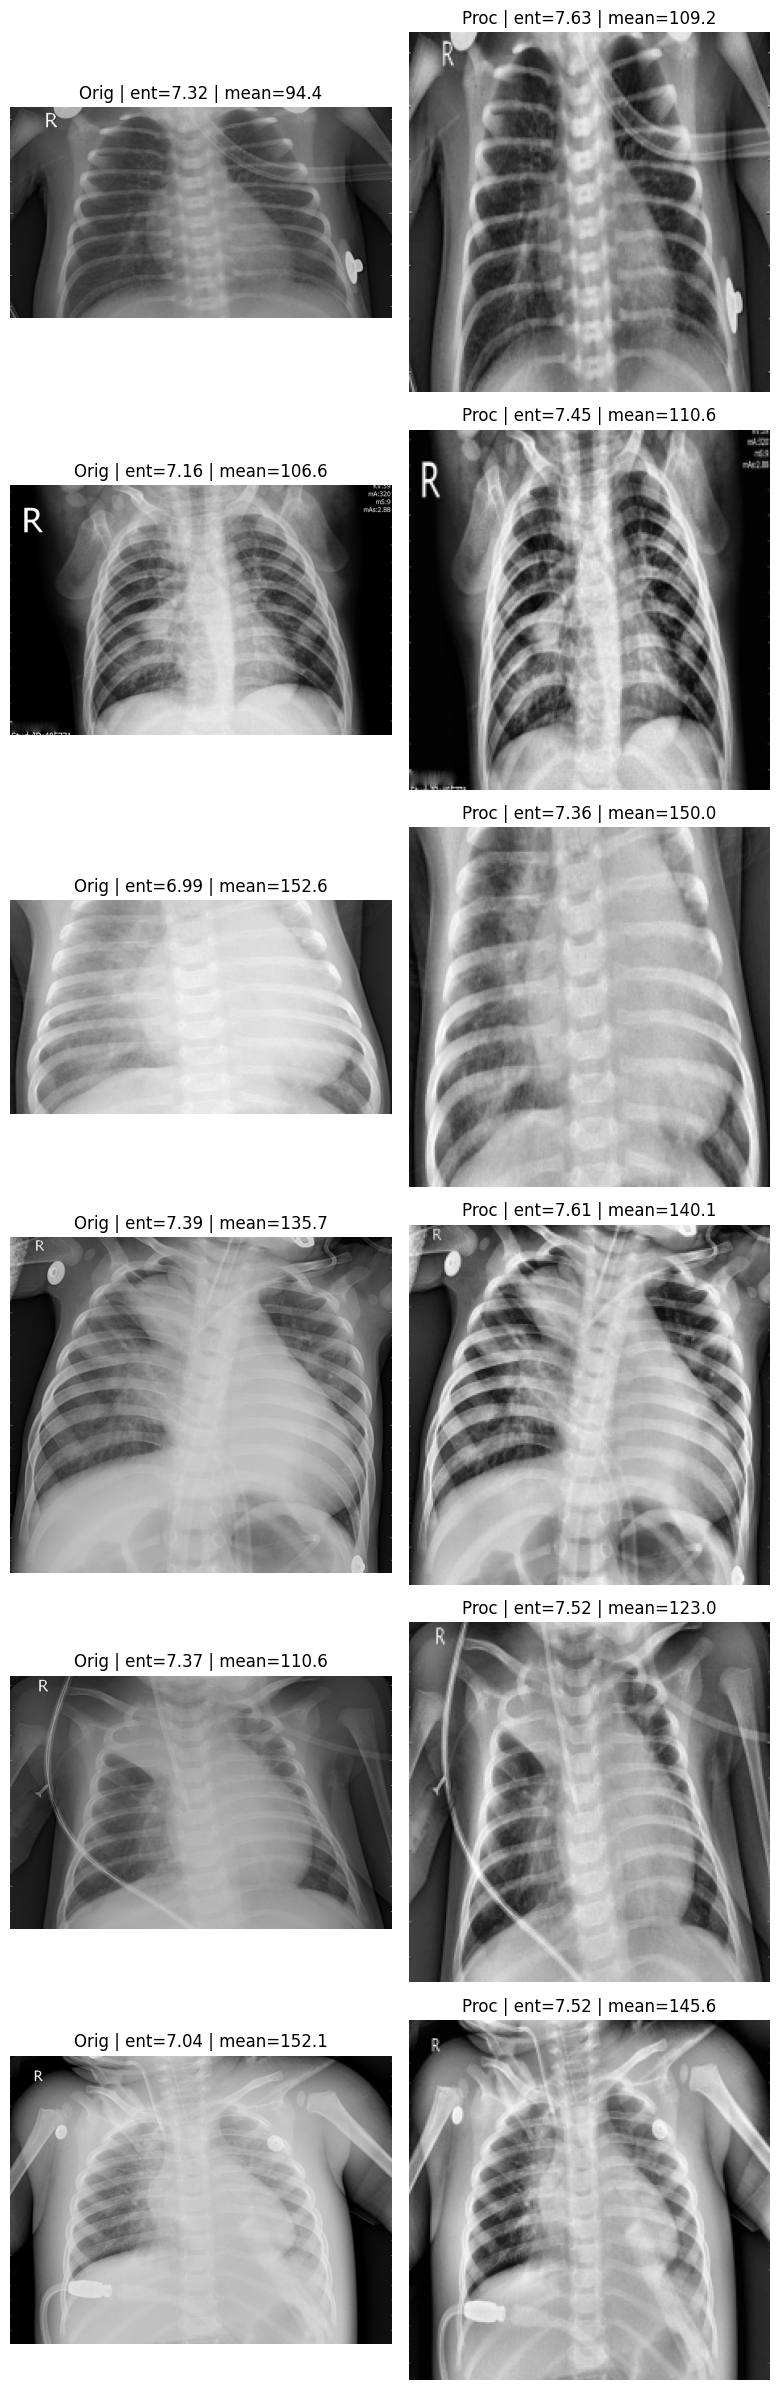

Figuras guardadas en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\exploracion\figures


In [18]:
df_stats = pd.DataFrame(rows)
df_stats.to_csv(Path(OUTPUT_TABLES) / 'before_after_stats.csv', index=False)
print("Guardado:", Path(OUTPUT_TABLES) / 'before_after_stats.csv')

# ---- 1) Histogramas de intensidad (antes vs después) ----
plt.figure(figsize=(10,5))
# concatenar todos los pixeles en arrays para antes y despues (muestrear por memoria)
pix_before = []
pix_after = []
for _, r in df_stats.sample(n=min(5000, len(df_stats)), random_state=0).iterrows():
    img_o = cv2.imread(r['original_path'], cv2.IMREAD_GRAYSCALE)
    img_p = cv2.imread(r['processed_path'], cv2.IMREAD_GRAYSCALE)
    if img_o is None or img_p is None:
        continue
    pix_before.append(img_o.ravel())
    pix_after.append(img_p.ravel())
if pix_before:
    pix_before = np.concatenate(pix_before).astype(np.int32)
    pix_after = np.concatenate(pix_after).astype(np.int32)
    bins = np.linspace(0,255,256)
    plt.hist(pix_before, bins=bins, density=True, alpha=0.5, label='Antes (muestra)', histtype='stepfilled')
    plt.hist(pix_after,  bins=bins, density=True, alpha=0.5, label='Después (muestra)', histtype='stepfilled')
    plt.xlabel('Intensidad (0-255)')
    plt.ylabel('Densidad')
    plt.title('Histograma de intensidades: Antes vs Después (muestra)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / 'hist_intensity_before_after.png', dpi=150)
    plt.show()

# ---- 2) Boxplots pareados: entropía y desviación local ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
data_ent = [df_stats['entropy_o'].dropna(), df_stats['entropy_p'].dropna()]
plt.boxplot(data_ent, labels=['Entropy antes','Entropy después'])
plt.title('Entropía antes vs después')

plt.subplot(1,2,2)
data_loc = [df_stats['localstd_o'].dropna(), df_stats['localstd_p'].dropna()]
plt.boxplot(data_loc, labels=['LocalStd antes','LocalStd después'])
plt.title(f'Desviación local (ksize={KSIZE_LOCAL_STD})')
plt.tight_layout()
plt.savefig(FIG_DIR / 'boxplots_entropy_localstd.png', dpi=150)
plt.show()

# ---- 3) Scatter: entropía antes vs después ----
plt.figure(figsize=(6,6))
plt.scatter(df_stats['entropy_o'], df_stats['entropy_p'], s=20, alpha=0.6)
mn = min(df_stats['entropy_o'].min(), df_stats['entropy_p'].min())
mx = max(df_stats['entropy_o'].max(), df_stats['entropy_p'].max())
plt.plot([mn,mx],[mn,mx],'r--', label='x=y')
plt.xlabel('Entropy antes')
plt.ylabel('Entropy después')
plt.title('Entropía: antes vs después (cada punto = 1 imagen)')
plt.legend()
plt.savefig(FIG_DIR / 'scatter_entropy_before_after.png', dpi=150)
plt.show()

# ---- 4) Mostrar pares de ejemplo (6 pares) ----
N_PAIRS_SHOW = 6
sample_show = df_stats.sample(n=min(N_PAIRS_SHOW, len(df_stats)), random_state=1).reset_index(drop=True)
cols = 2
rows = sample_show.shape[0]
plt.figure(figsize=(8, 4*rows))
for i, r in sample_show.iterrows():
    orig = cv2.imread(r['original_path'], cv2.IMREAD_GRAYSCALE)
    proc = cv2.imread(r['processed_path'], cv2.IMREAD_GRAYSCALE)
    if orig is None or proc is None:
        continue
    plt.subplot(rows, cols, 2*i+1)
    plt.imshow(orig, cmap='gray')
    plt.title(f"Orig | ent={r['entropy_o']:.2f} | mean={r['mean_o']:.1f}")
    plt.axis('off')
    plt.subplot(rows, cols, 2*i+2)
    plt.imshow(proc, cmap='gray')
    plt.title(f"Proc | ent={r['entropy_p']:.2f} | mean={r['mean_p']:.1f}")
    plt.axis('off')
plt.tight_layout()
plt.savefig(FIG_DIR / 'sample_pairs_before_after.png', dpi=150)
plt.show()

print("Figuras guardadas en:", FIG_DIR)


---------------------------------------------------------------------------------------------------------------

# Trabajo 03 — Parte 2: Extracción de Descriptores Clásicos

## A. Descriptores de Forma

In [19]:
from src.descriptores_forma.hog_extractor import extract_hog
from src.descriptores_forma.hu_moments import extract_hu_moments
from src.descriptores_forma.contour_features import extract_contour_features
from src.descriptores_forma.fourier_descriptor import extract_fourier

In [20]:
df_processed = pd.DataFrame(processed_records)

In [21]:
# =====================================================
# 🔹 PROCESAR TODAS LAS IMÁGENES Y EXTRAER FEATURES
# =====================================================

def process_all_descriptors(df):
    hog_list = []
    hu_list = []
    contour_list = []
    fourier_list = []

    for idx, row in df.iterrows():
        img = cv2.imread(row["processed_path"], cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Error loading image: {row['processed_path']}")
            continue

        # --- HOG ---
        hog_features, _ = extract_hog(img)

        # --- Hu Moments ---
        hu = extract_hu_moments(img)

        # --- Contour descriptors ---
        contour = extract_contour_features(img)

        # --- Fourier Descriptors ---
        fourier = extract_fourier(img)

        hog_list.append(hog_features)
        hu_list.append(hu)
        contour_list.append(contour)
        fourier_list.append(fourier)

    # Convertir a DataFrame
    hog_df = pd.DataFrame(hog_list)
    hu_df = pd.DataFrame(hu_list, columns=[f"Hu_{i+1}" for i in range(7)])
    contour_df = pd.DataFrame(contour_list)
    fourier_df = pd.DataFrame(fourier_list)

    final_df = pd.concat([hog_df, hu_df, contour_df, fourier_df], axis=1)

    return final_df


In [22]:
# =====================================================
# 🔹 VISUALIZACIÓN DE IMÁGENES PROCESADAS (TU CÓDIGO)
# =====================================================

def show_processed_examples(df_processed):
    # Solo filas con processed == True
    sample_proc = df_processed[df_processed['processed']].sample(
        min(6, len(df_processed)), random_state=0
    )

    n = len(sample_proc)
    cols = min(3, n)
    rows = (n + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axs = axs.flatten() if n > 1 else [axs]

    for ax, (_, r) in zip(axs, sample_proc.iterrows()):
        try:
            im = Image.open(r['processed_path'])
            ax.imshow(im.convert('L'), cmap='gray')
            ax.set_title(f"{r['split']}/{r['class']}\n{Path(r['processed_path']).name}")
            ax.axis('off')
        except Exception as e:
            ax.set_title("Error")

    plt.tight_layout()
    plt.show()



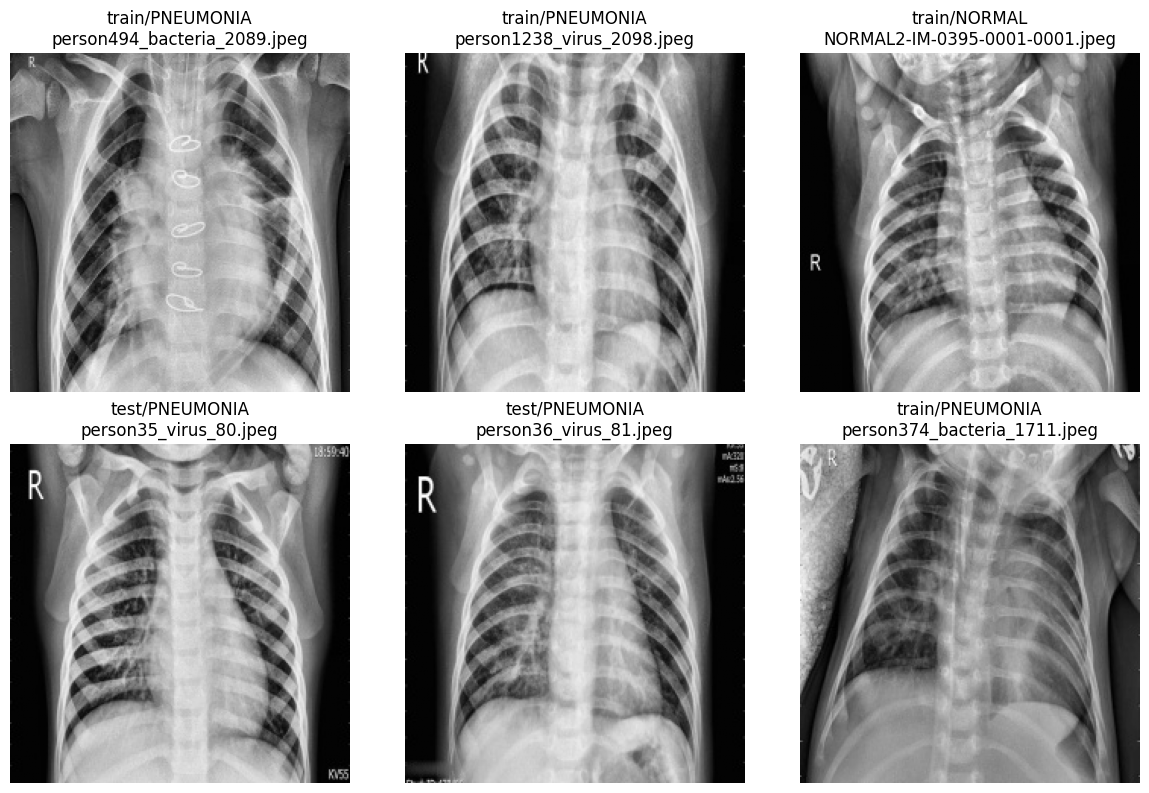

Shape final de features: (5856, 6115)


0         1         2         3         4         5         6   \
0  0.203834  0.012412  0.000000  0.003551  0.015475  0.006821  0.021663   
1  0.284989  0.177483  0.022861  0.001772  0.011223  0.003468  0.082553   
2  0.074675  0.001088  0.001720  0.001088  0.004378  0.001632  0.025871   
3  0.293036  0.013000  0.002412  0.000763  0.042670  0.006823  0.002185   
4  0.079337  0.016680  0.021874  0.017812  0.153383  0.312195  0.312195   

         7         8         9   ...           10           11           12  \
0  0.370478  0.384292  0.224293  ...   527.210075  1947.609973   319.771305   
1  0.146121  0.284989  0.122473  ...   167.660018  2767.108365   892.402124   
2  0.297185  0.297185  0.113004  ...  1745.549520  1416.097650   650.948845   
3  0.293036  0.293036  0.250303  ...   217.651142   543.113239   933.104651   
4  0.143870  0.014744  0.210894  ...   726.013157  1093.323653  1564.579714   

            13           14           15           16           17  \
0   332.285734   725.016542   715.157900   393.593262   510.837768   
1  1508.111056   430.603975  1087.205507   417.446426   134.167560   
2  1739.221450  1053.510317  1430.724366  1375.156643   673.709812   
3   767.568236   137.834550   877.211153   836.923052   473.649504   
4   888.160571  1623.120123  1046.117502  1419.271995  1022.763695   

            18          19  
0   676.563927  823.656829  
1   836.251014  367.581507  
2   470.730659  840.769509  
3   256.317534  797.619904  
4  1022.168022  515.296023  

[5 rows x 6115 columns]

In [23]:
# =====================================================
# 🔹 EJECUCIÓN COMPLETA
# =====================================================

# Visualización
show_processed_examples(df_processed)

# Extracción de features
features_df = process_all_descriptors(df_processed[df_processed["processed"] == True])

print("Shape final de features:", features_df.shape)
features_df.head()

In [24]:
def visualize_descriptors(df, output_dir=None):
    import random
    import numpy as np

    # Usar la ruta real que tú ya definiste
    global OUTPUT_FIGS_FT
    if output_dir is None:
        output_dir = OUTPUT_FIGS_FT

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)   # no crea carpeta nueva, solo asegura que exista

    # Seleccionar una imagen procesada al azar
    row = df[df["processed"] == True].sample(1, random_state=None).iloc[0]
    img = cv2.imread(row["processed_path"], cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("❌ Error loading image.")
        return

    # --------- Extraer descriptores ---------
    hog_features, hog_image = extract_hog(img)
    hu = extract_hu_moments(img)
    contour = extract_contour_features(img)
    fourier = extract_fourier(img)

    # Contornos para visualizar
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key=cv2.contourArea) if len(cnts) > 0 else None

    # --------- Mostrar todo ---------
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Imagen original
    axs[0,0].imshow(img, cmap="gray")
    axs[0,0].set_title("Imagen original")
    axs[0,0].axis("off")

    # HOG
    axs[0,1].imshow(hog_image, cmap="gray")
    axs[0,1].set_title("HOG visualization")
    axs[0,1].axis("off")

    # Contorno
    contour_img = np.stack([img]*3, axis=-1)
    if cnt is not None:
        cv2.drawContours(contour_img, [cnt], -1, (0,255,0), 2)

    axs[1,0].imshow(contour_img)
    axs[1,0].set_title("Contorno principal")
    axs[1,0].axis("off")

    # Fourier descriptor (gráfico de magnitudes)
    axs[1,1].plot(fourier)
    axs[1,1].set_title("Descriptores de Fourier (magnitudes)")
    axs[1,1].set_xlabel("Coeficiente")
    axs[1,1].set_ylabel("Magnitud")

    plt.suptitle(f"Ejemplo de descriptores para: {Path(row['processed_path']).name}", y=1.02)
    plt.tight_layout()

    # --------- GUARDAR FIGURA ---------
    class_name = row["class"] if "class" in row else "unknown"

    file_name = f"{class_name}_descriptores_forma.png"
    out_file = output_dir / file_name
    fig.savefig(out_file, dpi=150)

    plt.show()

    print(f"\n✅ Figura guardada en: {out_file}")

    print("\nMomentos de Hu:")
    for i, v in enumerate(hu):
        print(f"  Hu[{i+1}] = {v}")




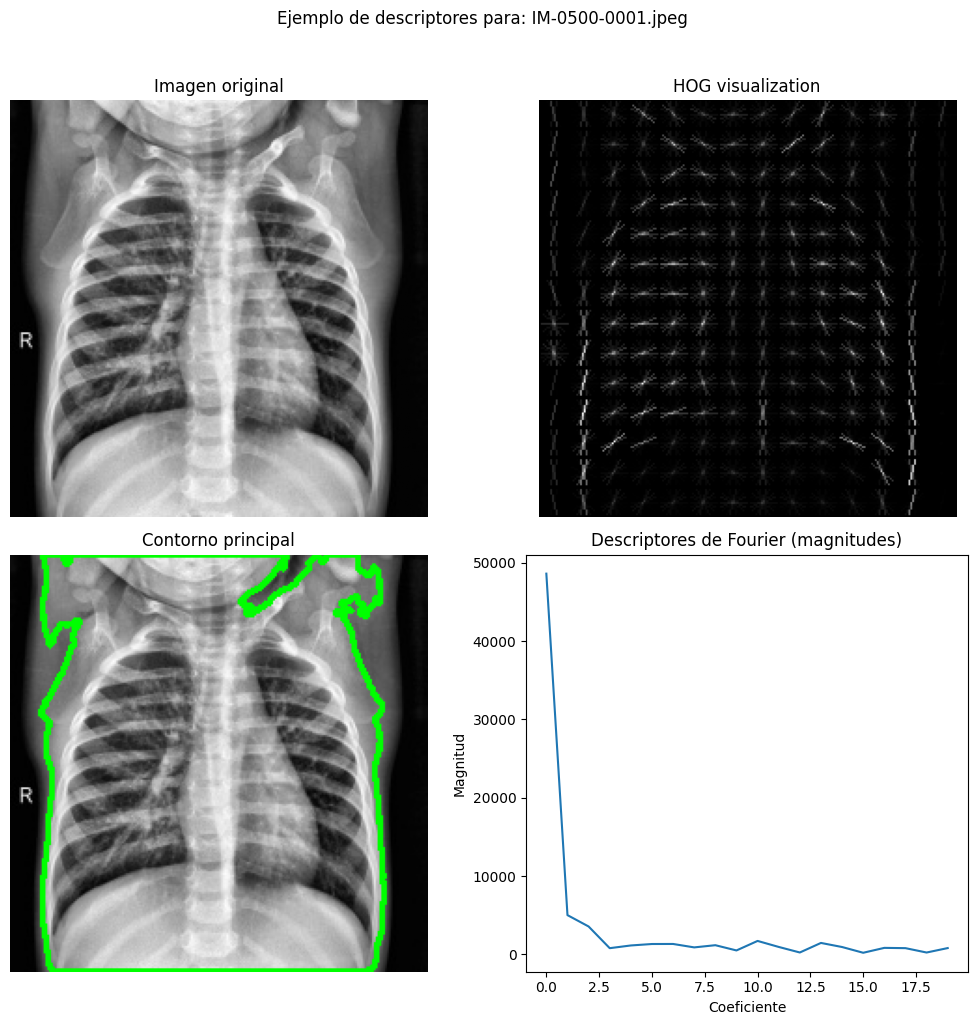


✅ Figura guardada en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\descriptores_forma\figures\NORMAL_descriptores_forma.png

Momentos de Hu:
  Hu[1] = 0.001213374449147007
  Hu[2] = 8.444793068149325e-08
  Hu[3] = 1.8626141687288956e-12
  Hu[4] = 5.999344829345561e-13
  Hu[5] = -1.6039151239663858e-25
  Hu[6] = 1.4868806697745872e-16
  Hu[7] = -6.135694271489878e-25


In [25]:
visualize_descriptors(df_processed)

In [26]:
features_df

0         1         2         3         4         5         6   \
0     0.203834  0.012412  0.000000  0.003551  0.015475  0.006821  0.021663   
1     0.284989  0.177483  0.022861  0.001772  0.011223  0.003468  0.082553   
2     0.074675  0.001088  0.001720  0.001088  0.004378  0.001632  0.025871   
3     0.293036  0.013000  0.002412  0.000763  0.042670  0.006823  0.002185   
4     0.079337  0.016680  0.021874  0.017812  0.153383  0.312195  0.312195   
...        ...       ...       ...       ...       ...       ...       ...   
5851  0.267483  0.267483  0.267483  0.267483  0.267483  0.102267  0.118457   
5852  0.267971  0.210684  0.267971  0.267971  0.237761  0.064446  0.048586   
5853  0.293130  0.165750  0.293130  0.207516  0.293130  0.293130  0.201155   
5854  0.304771  0.304771  0.304771  0.121822  0.122716  0.026500  0.036582   
5855  0.060652  0.119259  0.331158  0.331158  0.054163  0.003607  0.004452   

            7         8         9   ...           10           11  \
0     0.370478  0.384292  0.224293  ...   527.210075  1947.609973   
1     0.146121  0.284989  0.122473  ...   167.660018  2767.108365   
2     0.297185  0.297185  0.113004  ...  1745.549520  1416.097650   
3     0.293036  0.293036  0.250303  ...   217.651142   543.113239   
4     0.143870  0.014744  0.210894  ...   726.013157  1093.323653   
...        ...       ...       ...  ...          ...          ...   
5851  0.237422  0.214356  0.169768  ...   498.819039  1100.690778   
5852  0.032094  0.267971  0.248116  ...   431.036635  1078.957825   
5853  0.224490  0.293130  0.103836  ...  1045.642614   576.234452   
5854  0.139326  0.304771  0.174355  ...  1229.939914   478.150533   
5855  0.004282  0.005125  0.031213  ...  1357.285907   346.194886   

               12           13           14           15           16  \
0      319.771305   332.285734   725.016542   715.157900   393.593262   
1      892.402124  1508.111056   430.603975  1087.205507   417.446426   
2      650.948845  1739.221450  1053.510317  1430.724366  1375.156643   
3      933.104651   767.568236   137.834550   877.211153   836.923052   
4     1564.579714   888.160571  1623.120123  1046.117502  1419.271995   
...           ...          ...          ...          ...          ...   
5851   652.515835   420.408408   912.811471   267.454708   812.229128   
5852  1012.029663   650.220285   985.138807   587.912493    92.429363   
5853   615.753471   453.799541   609.525044   410.594068   678.024236   
5854   609.988167   975.856677   340.875371   824.967969   331.792602   
5855   967.060012   575.833292  1036.174154   309.871675   436.445676   

               17           18          19  
0      510.837768   676.563927  823.656829  
1      134.167560   836.251014  367.581507  
2      673.709812   470.730659  840.769509  
3      473.649504   256.317534  797.619904  
4     1022.763695  1022.168022  515.296023  
...           ...          ...         ...  
5851   664.458534   643.005530  502.689518  
5852   130.209503   260.457626  420.653685  
5853   751.915774   282.334501  302.142740  
5854   465.527771   420.333397  226.811632  
5855   138.643602    86.742790  402.294731  

[5856 rows x 6115 columns]

In [27]:
features_df.to_csv(OUTPUT_TABLES_FT / 'part2_a_processed_files.csv', index=False)

Al aplicar los descriptores de forma seleccionados (HOG, Momentos de Hu y descriptores basados en contornos), obtuve un conjunto de más de 6000 características por imagen. Esto ocurre porque el descriptor HOG genera un vector muy grande dependiendo del tamaño de la imagen y del número de celdas y orientaciones. A ese vector se suman los 7 Momentos de Hu, además de medidas geométricas como área, perímetro, circularidad y excentricidad.

HOG captura bien la estructura global y los bordes característicos en las radiografías.
Esto es útil porque las imágenes con neumonía tienden a mostrar patrones más irregulares y difusos, mientras que las normales presentan regiones más limpias y definidas.

Los Momentos de Hu resultaron ser valores muy pequeños (en rangos cercanos a 10⁻⁸ a 10⁻¹²). Esto es completamente normal, porque estos momentos están diseñados para ser invariantes a rotación, escala y traslación. Su magnitud baja indica estabilidad, no error.

Las métricas de contorno como circularidad y excentricidad mostraron variación entre imágenes, reflejando diferencias en la forma de la región segmentada. Aunque la anatomía torácica no tiene contornos simples, estas medidas complementan la descripción general.

En conjunto, estos descriptores proporcionan una representación numérica rica que resume la forma de las estructuras visibles en los rayos X. Esta matriz servirá como base para la comparación con los métodos de Deep Learning en las siguientes partes del taller.

## B. Descriptores de Textura

In [28]:
from src.descriptores_textura.texture_lbp import compute_lbp
from src.descriptores_textura.texture_glcm import compute_glcm_features
from src.descriptores_textura.texture_gabor import compute_gabor_features
from src.descriptores_textura.texture_firstorder import compute_first_order

In [29]:
records = []

print("Extrayendo descriptores de textura...")

df_valid = df_processed[df_processed['processed']]

for _, row in tqdm(df_valid.iterrows(), total=len(df_valid)):
    img_path = Path(row['processed_path'])
    img = np.array(Image.open(img_path))

    # Calcular descriptores
    lbp_img, lbp_hist = compute_lbp(img)
    glcm_feats = compute_glcm_features(img)
    gabor_feats = compute_gabor_features(img)
    first_feats = compute_first_order(img)

    # Crear registro
    record = {
        "path": str(img_path),
        "split": row["split"],
        "class": row["class"],
    }

    # LBP: histograma
    for i, h in enumerate(lbp_hist):
        record[f"lbp_{i}"] = h

    # GLCM: 4 características
    record.update(glcm_feats)

    # Gabor: medias y stds
    record.update(gabor_feats)

    # Primer orden: 5 características
    record.update(first_feats)

    records.append(record)

#  Guardar CSV
df_textures = pd.DataFrame(records)
output_path = OUTPUT_TABLES_TEXTURE / "texture_features.csv"
df_textures.to_csv(output_path, index=False)

print("\n Descriptores de textura extraídos correctamente.")
print("Archivo guardado en:", output_path)

df_textures.head()


Extrayendo descriptores de textura...


100%|██████████| 5856/5856 [09:18<00:00, 10.48it/s]



 Descriptores de textura extraídos correctamente.
Archivo guardado en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\descriptores_textura\tables\texture_features.csv


path  split   class     lbp_0  \
0  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.042471   
1  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.045639   
2  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.037329   
3  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.044404   
4  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.043826   

      lbp_1     lbp_2     lbp_3     lbp_4     lbp_5     lbp_6  ...  \
0  0.064114  0.051200  0.112903  0.273517  0.170400  0.069256  ...   
1  0.059730  0.055983  0.116988  0.242666  0.158542  0.069137  ...   
2  0.059072  0.051339  0.110830  0.254145  0.155254  0.065549  ...   
3  0.063536  0.054408  0.115394  0.247270  0.172632  0.067463  ...   
4  0.058355  0.052954  0.109873  0.234216  0.145926  0.065649  ...   

   gabor_std_6  gabor_mean_7  gabor_std_7  gabor_mean_8  gabor_std_8  \
0   145.708847     57.608841    90.962921    211.875015   133.636276   
1   151.214142     51.798092    98.652199    189.555557   126.364380   
2   147.874466     53.824039    78.572166    197.161697   150.985306   
3   128.558609     58.680302    76.817459    215.009583   120.239449   
4   158.052689     52.169464    92.449883    191.247391   124.038330   

         mean     variance  skewness  kurtosis   entropy  
0  126.302655  3458.339921 -0.137961 -0.939920  5.420316  
1  113.446429  3888.811185 -0.131981 -0.904928  5.325319  
2  118.014629  4650.441232 -0.271059 -1.036078  5.247648  
3  128.697943  3652.680406 -0.359388 -0.917148  5.392274  
4  114.395767  4578.808531 -0.234783 -1.037436  5.213928  

[5 rows x 40 columns]

In [30]:
# Cargar datos
df = pd.read_csv("resultados/descriptores_textura/tables/texture_features.csv")
df.head()

path  split   class     lbp_0  \
0  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.042471   
1  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.045639   
2  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.037329   
3  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.044404   
4  C:\Users\USER\OneDrive\Escritorio\proyecto-ima...  train  NORMAL  0.043826   

      lbp_1     lbp_2     lbp_3     lbp_4     lbp_5     lbp_6  ...  \
0  0.064114  0.051200  0.112903  0.273517  0.170400  0.069256  ...   
1  0.059730  0.055983  0.116988  0.242666  0.158542  0.069137  ...   
2  0.059072  0.051339  0.110830  0.254145  0.155254  0.065549  ...   
3  0.063536  0.054408  0.115394  0.247270  0.172632  0.067463  ...   
4  0.058355  0.052954  0.109873  0.234216  0.145926  0.065649  ...   

   gabor_std_6  gabor_mean_7  gabor_std_7  gabor_mean_8  gabor_std_8  \
0    145.70885     57.608840     90.96292     211.87502    133.63628   
1    151.21414     51.798090     98.65220     189.55556    126.36438   
2    147.87447     53.824040     78.57217     197.16170    150.98530   
3    128.55861     58.680300     76.81746     215.00958    120.23945   
4    158.05269     52.169464     92.44988     191.24739    124.03833   

         mean     variance  skewness  kurtosis   entropy  
0  126.302655  3458.339921 -0.137961 -0.939920  5.420316  
1  113.446429  3888.811185 -0.131981 -0.904928  5.325319  
2  118.014629  4650.441232 -0.271059 -1.036078  5.247648  
3  128.697943  3652.680406 -0.359388 -0.917148  5.392274  
4  114.395767  4578.808531 -0.234783 -1.037436  5.213928  

[5 rows x 40 columns]

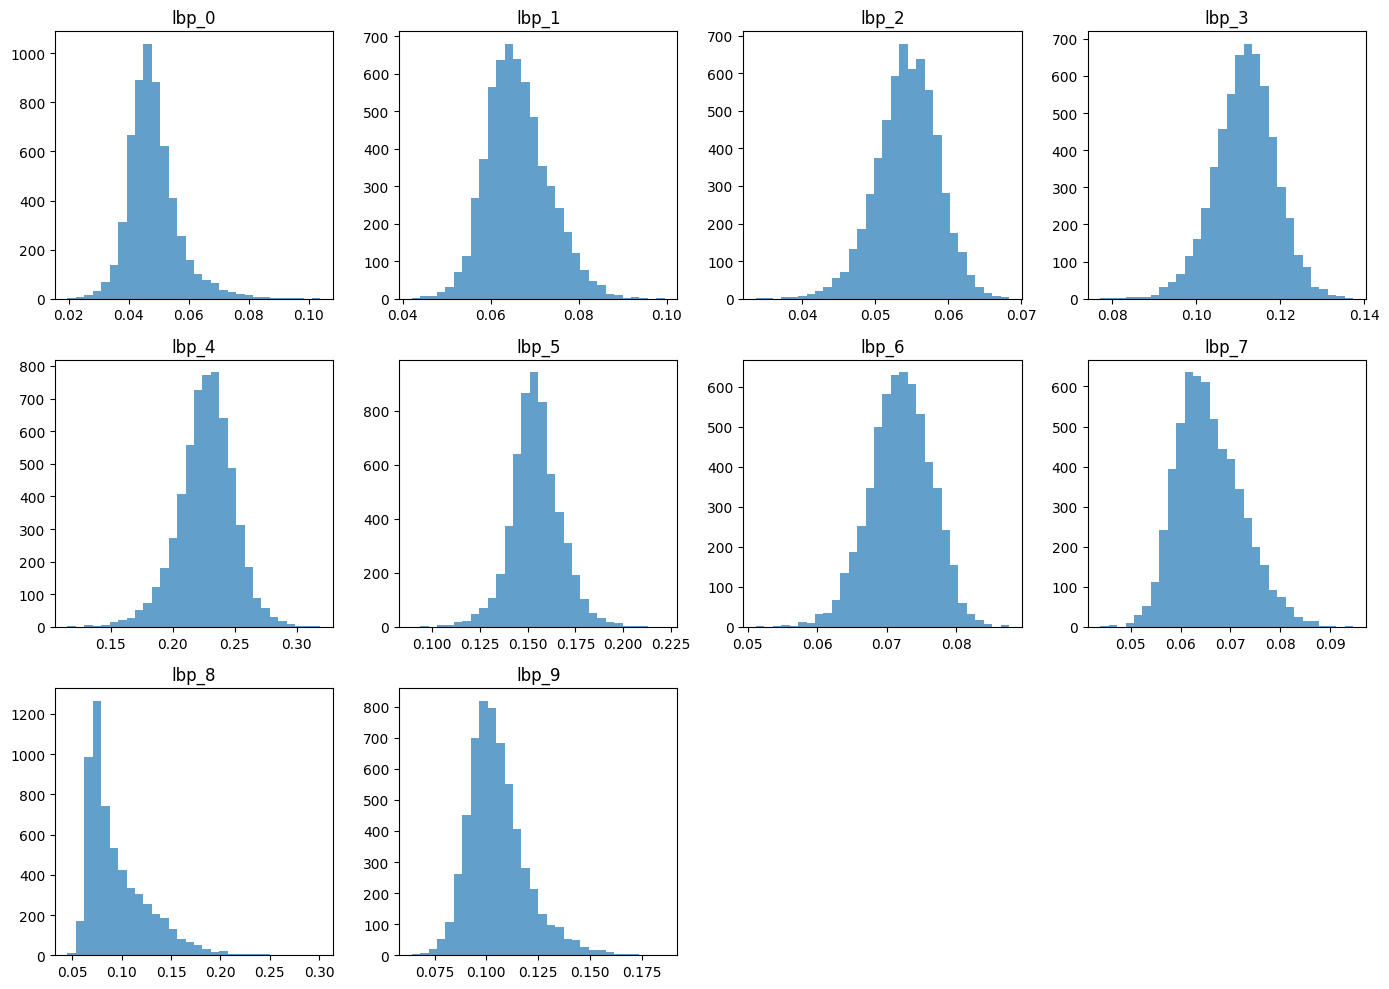

Guardado en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\descriptores_textura\figures\lbp_histograms.png


In [31]:
# Histogramas de LBP (LBP_0 a LBP_9)

# Seleccionar columnas de LBP
lbp_cols = [c for c in df.columns if c.startswith("lbp_")]

# Crear figura
plt.figure(figsize=(14, 10))

for i, col in enumerate(lbp_cols):
    plt.subplot(3, 4, i + 1)
    plt.hist(df[col], bins=30, alpha=0.7)
    plt.title(col)

plt.tight_layout()

# Guardar figura
out_file = OUTPUT_FIGS_TEXTURE / "lbp_histograms.png"
plt.savefig(out_file, dpi=300)

# Mostrar figura
plt.show()

print("Guardado en:", out_file)


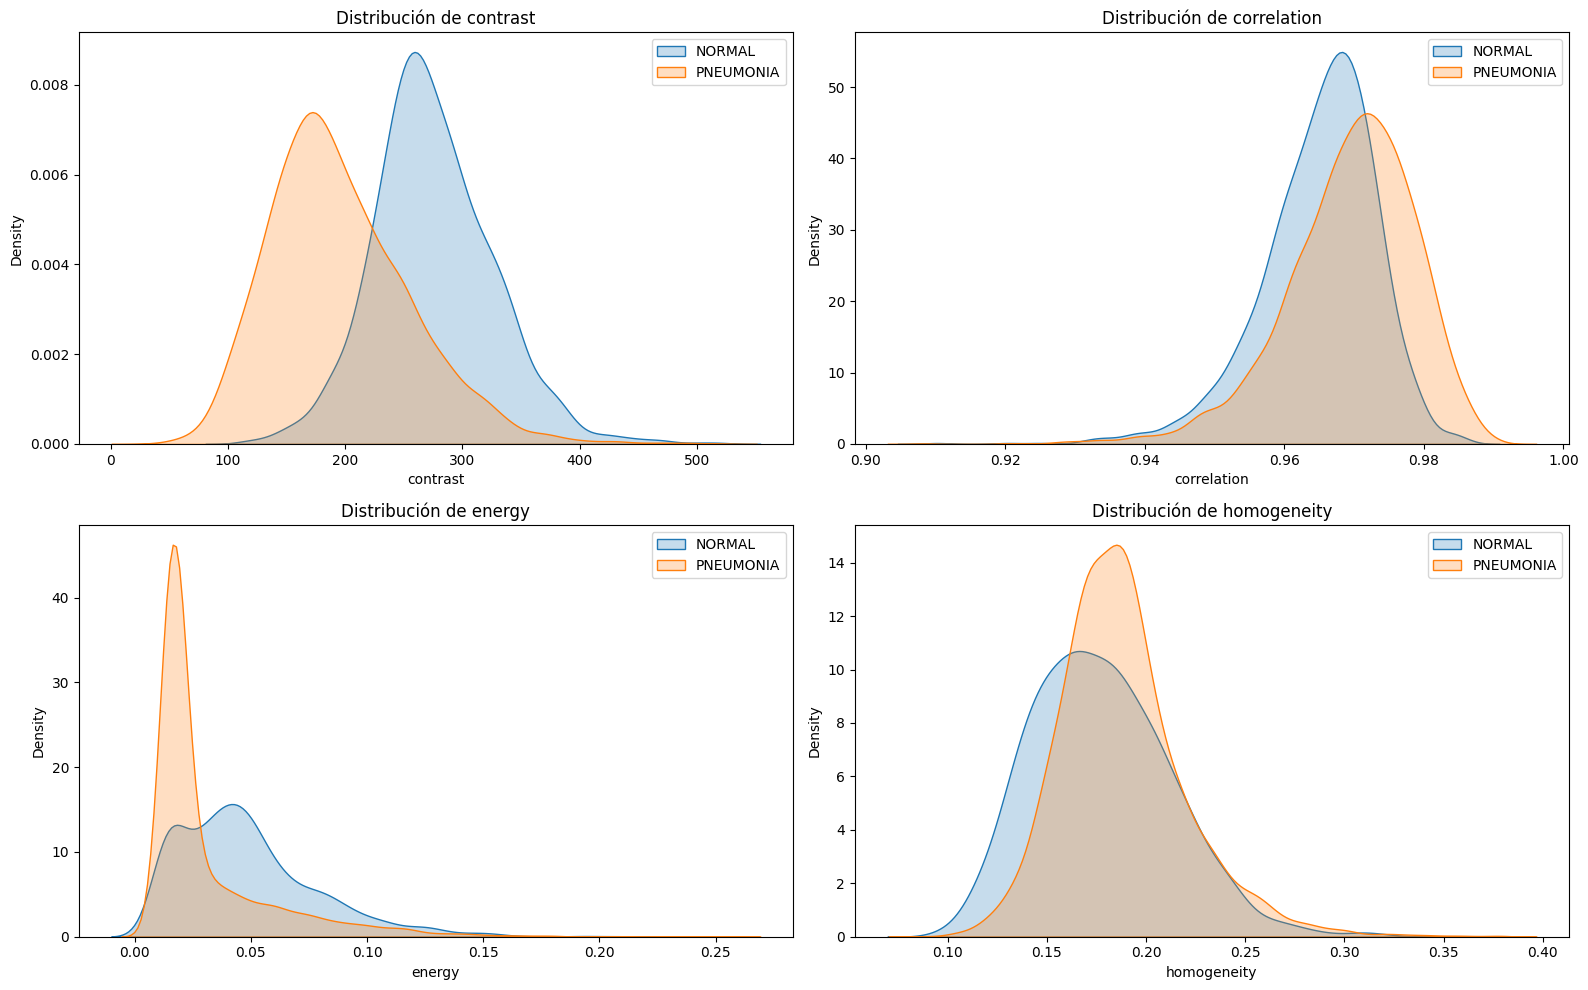

Guardado en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\descriptores_textura\figures\glcm_comparison_normal_vs_pneumonia.png


In [32]:
# Comparación NORMAL vs PNEUMONIA usando GLCM

glcm_cols = ["contrast", "correlation", "energy", "homogeneity"]

plt.figure(figsize=(16, 10))

for i, col in enumerate(glcm_cols):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df[df['class'] == "NORMAL"][col], label="NORMAL", fill=True)
    sns.kdeplot(df[df['class'] == "PNEUMONIA"][col], label="PNEUMONIA", fill=True)
    plt.title(f"Distribución de {col}")
    plt.legend()

plt.tight_layout()

# Guardar la figura
out_file = OUTPUT_FIGS_TEXTURE / "glcm_comparison_normal_vs_pneumonia.png"
plt.savefig(out_file, dpi=300)

# Mostrar figura
plt.show()

print("Guardado en:", out_file)


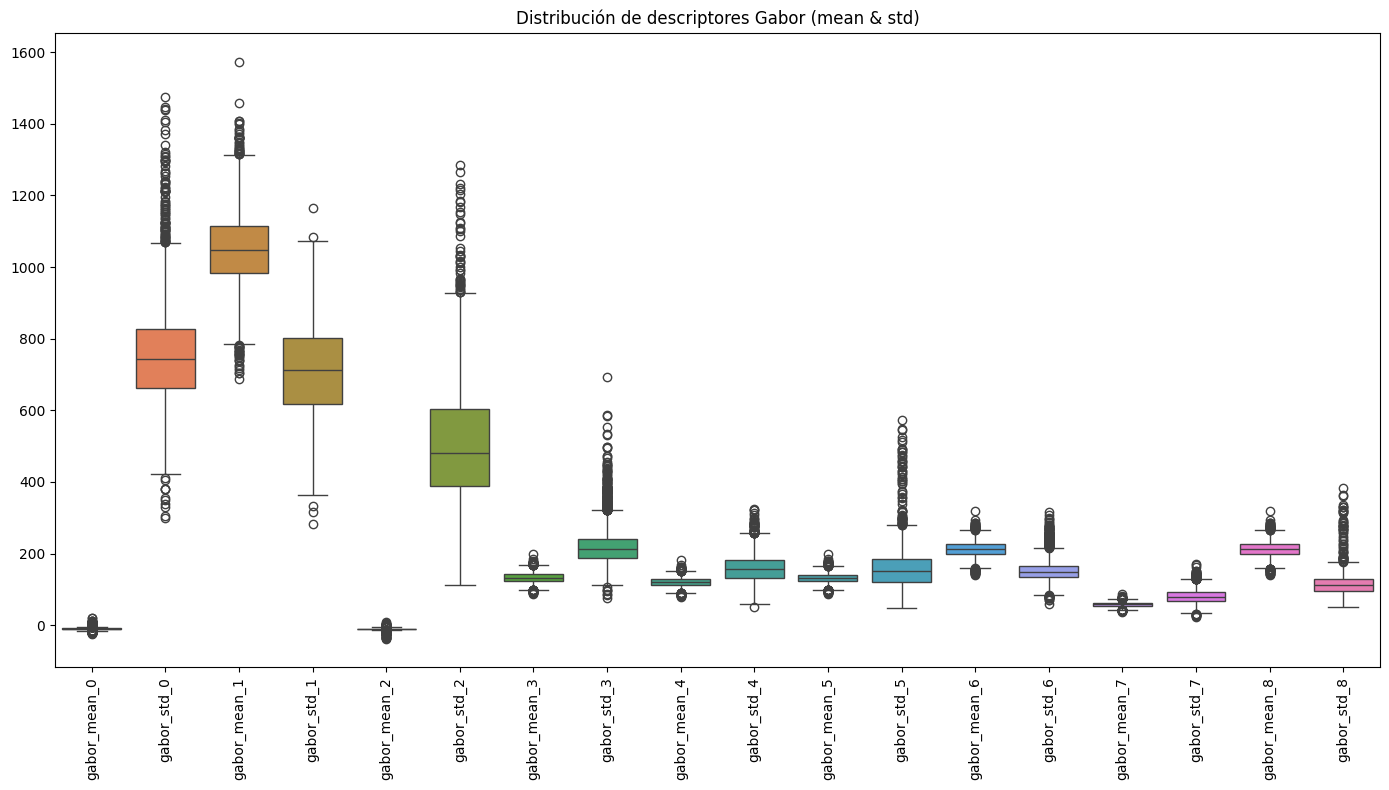

Guardado en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\descriptores_textura\figures\gabor_boxplots.png


In [33]:
# Boxplots de Filtros Gabor

gabor_cols = [c for c in df.columns if c.startswith("gabor")]

plt.figure(figsize=(14, 8))
sns.boxplot(data=df[gabor_cols])
plt.xticks(rotation=90)
plt.title("Distribución de descriptores Gabor (mean & std)")
plt.tight_layout()

# Guardar figura
out_file = OUTPUT_FIGS_TEXTURE / "gabor_boxplots.png"
plt.savefig(out_file, dpi=300)

# Mostrar figura
plt.show()

print("Guardado en:", out_file)


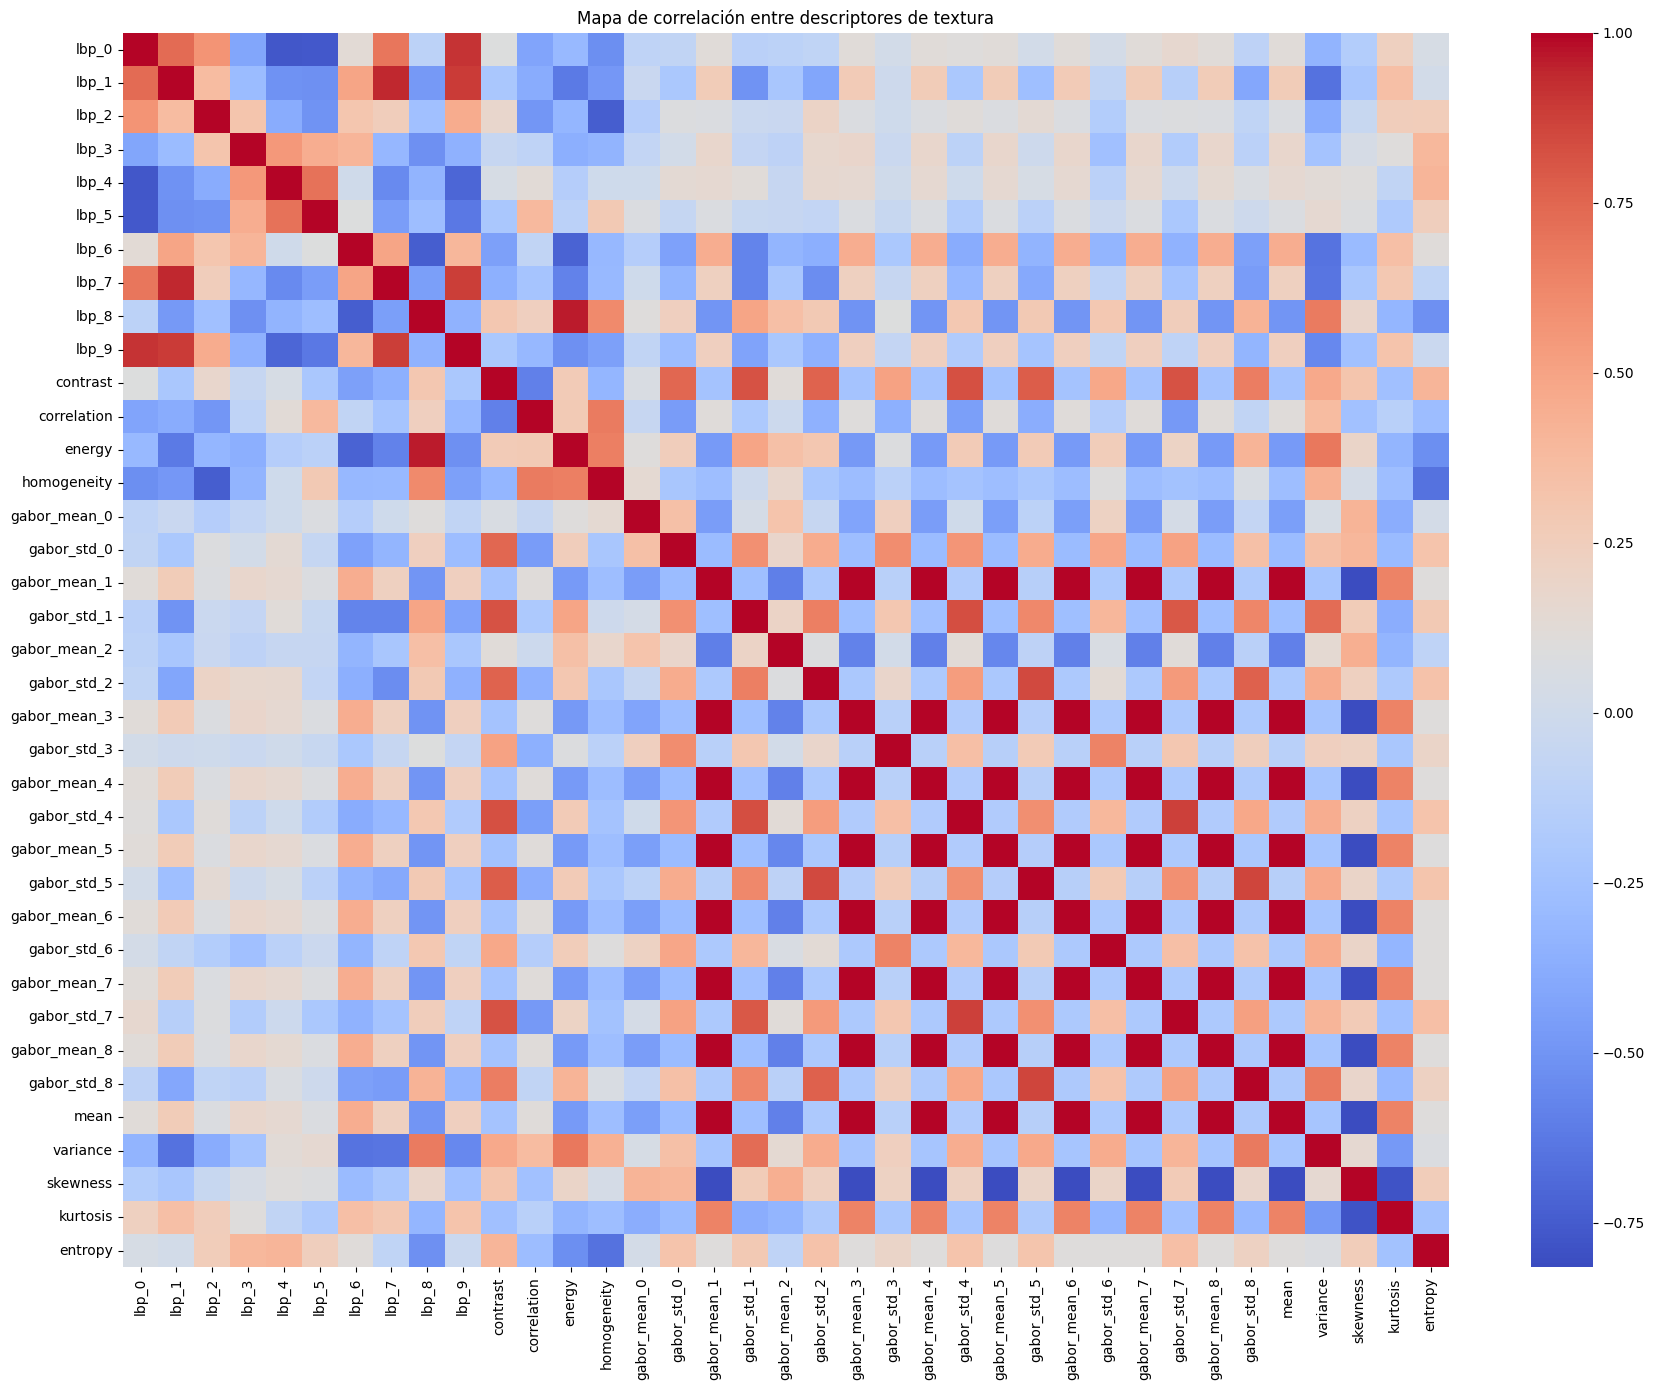

Guardado en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\descriptores_textura\figures\heatmap_correlacion.png


In [34]:
# Heatmap de correlación entre todos los descriptores

# Seleccionar solo columnas numéricas
num_df = df.select_dtypes(include='number')

plt.figure(figsize=(18, 14))
sns.heatmap(num_df.corr(), cmap='coolwarm', annot=False)
plt.title("Mapa de correlación entre descriptores de textura")
plt.tight_layout()

# Guardar figura
out_file = OUTPUT_FIGS_TEXTURE / "heatmap_correlacion.png"
plt.savefig(out_file, dpi=300)

# Mostrar
plt.show()

print("Guardado en:", out_file)


-------------------------------------------------------------------------------------------------------------------------------

# Trabajo 03 — Parte 3: Clasificación con Descriptores Clásicos

### ✅ Módulo de extracción y aplanado de características

El componente `flatten_feature` contenido en el modulo `features_extract.py` unifica cualquier salida de nuestras funciones de descriptores (arrays, listas, tuplas, diccionarios o escalares) en un vector NumPy 1-D de `float32`, asegurando un orden determinista cuando la entrada es un diccionario. Esto permite concatenar características heterogéneas sin pérdida de coherencia.

La función `extract_features` centraliza la extracción de descriptores para una imagen: invoca las funciones (HOG, HU, contorno, LBP, GLCM y Gabor), corrige el *unpack* de `compute_lbp`, aplana cada descriptor y genera nombres consistentes.  

El resultado final es un vector 1-D listo para alimentar un clasificador tradicional, y opcionalmente, la lista ordenada de nombres de cada componente del vector.


In [35]:
from src.clasificacion.features_extract import flatten_feature

In [36]:
def extract_features(img: np.ndarray, return_names: bool = False) -> Union[np.ndarray, Tuple[np.ndarray, List[str]]]:
    """
    Extrae y concatena características de la imagen `img`.

    - Corrige el unpack de compute_lbp (nota: compute_lbp devuelve (lbp_image, hist)).
    - Acepta que algunas funciones devuelvan dicts o scalars.
    - Por defecto devuelve solo el vector; si return_names=True también devuelve
      la lista de nombres en el mismo orden.

    Retorna
    -------
    features : np.ndarray (1-D float32)
    o (features, names) si return_names=True
    """
    # llamadas a tus funciones (asumo están definidas en el scope)
    feat_hog, _ = extract_hog(img)                 # hog_features, hog_image
    feat_hu = extract_hu_moments(img)              # np.ndarray (7,)
    feat_contour = extract_contour_features(img)   # dict
    # CORRECCIÓN: compute_lbp devuelve (lbp_image, hist)
    _, feat_lbp = compute_lbp(img)                 # lbp_image, hist -> queremos el hist (1-D)
    feat_glcm = compute_glcm_features(img)         # dict
    feat_gabor = compute_gabor_features(img)       # dict

    # Pares (prefijo, objeto) para producir nombres legibles
    pairs = [
        ("hog", feat_hog),
        ("hu", feat_hu),
        ("contour", feat_contour),
        ("lbp", feat_lbp),
        ("glcm", feat_glcm),
        ("gabor", feat_gabor),
    ]

    parts = []
    feature_names: List[str] = []

    for prefix, obj in pairs:
        arr, keys = flatten_feature(obj)
        parts.append(arr)

        if keys is not None:
            # si vino de dict usamos las keys ordenadas
            feature_names.extend([f"{prefix}_{k}" for k in keys])
        else:
            # si no, generamos nombres genéricos prefix_i
            feature_names.extend([f"{prefix}_{i}" for i in range(arr.size)])

    # finalmente concatenamos
    if len(parts) == 0:
        features = np.array([], dtype=np.float32)
    else:
        features = np.concatenate(parts).astype(np.float32)

    if return_names:
        return features, feature_names
    return features


✅ Construcción del dataset y extracción masiva de características

La función `process_dataset` automatiza todo el flujo de extracción de características para cada imagen del conjunto preprocesado. Asume una estructura clara del dataset con carpetas train/, val/ y test/, cada una subdividida en NORMAL/ y PNEUMONIA/.

Para cada split, la función:

* Recorre las carpetas correspondientes y detecta únicamente archivos válidos (.jpg, .jpeg, .png).

* Carga cada imagen en escala de grises para asegurar uniformidad en los descriptores.

* Aplica la función extract_features, que genera un vector numérico homogéneo combinando HOG, HU, contorno, LBP, GLCM y Gabor.

* Almacena el vector resultante junto con su etiqueta (0 = NORMAL, 1 = PNEUMONIA).

El resultado final es un diccionario X_splits con matrices de características por split, y y_splits con las etiquetas correspondientes, listo para alimentar cualquier modelo clásico de Machine Learning o para análisis estadístico.

In [37]:
# Realizamos la extracción de features y creación de arrays para train/val/test

def process_dataset(base_dir):
    """
    base_dir: carpeta base que contiene subcarpetas train/val/test
              y dentro de cada una NORMAL / PNEUMONIA
    Retorna:
        X_splits: dict con arrays de features por split
        y_splits: dict con arrays de etiquetas por split
    """
    splits = ["train", "val", "test"]
    clases = ["NORMAL", "PNEUMONIA"]

    X_splits = {}
    y_splits = {}

    for split in splits:
        X = []
        y = []

        split_dir = os.path.join(base_dir, split)
        for cls in clases:
            label = 0 if cls == "NORMAL" else 1
            folder = os.path.join(split_dir, cls)

            # Seguridad: por si falta alguna carpeta
            if not os.path.isdir(folder):
                continue

            for fname in os.listdir(folder):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    path = os.path.join(folder, fname)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        continue  # por si alguna imagen está dañada

                    features = extract_features(img)
                    X.append(features)
                    y.append(label)

        X_splits[split] = np.array(X)
        y_splits[split] = np.array(y)

    return X_splits, y_splits

base_dir = DATA_PROCESSED

X_splits, y_splits = process_dataset(base_dir)

X_train, y_train = X_splits["train"], y_splits["train"]
X_val,   y_val   = X_splits["val"],   y_splits["val"]
X_test,  y_test  = X_splits["test"],  y_splits["test"]

In [38]:
X_splits

{'train': array([[2.0383438e-01, 1.2412364e-02, 0.0000000e+00, ..., 1.4570885e+02,
         9.0962921e+01, 1.3363628e+02],
        [2.8498882e-01, 1.7748293e-01, 2.2861298e-02, ..., 1.5121414e+02,
         9.8652199e+01, 1.2636438e+02],
        [7.4675284e-02, 1.0878112e-03, 1.7199805e-03, ..., 1.4787447e+02,
         7.8572166e+01, 1.5098531e+02],
        ...,
        [2.6754302e-01, 2.8962465e-02, 2.7691105e-01, ..., 1.0984387e+02,
         6.3213017e+01, 9.9725021e+01],
        [2.4078821e-01, 2.0923319e-01, 1.7925586e-01, ..., 1.2939143e+02,
         8.5004082e+01, 1.0036029e+02],
        [2.3641494e-01, 2.3641494e-01, 2.3641494e-01, ..., 1.2055713e+02,
         6.6641388e+01, 8.4370201e+01]], shape=(5216, 6127), dtype=float32),
 'val': array([[8.8998921e-02, 3.0879888e-03, 4.3133190e-03, ..., 1.3816046e+02,
         8.3923538e+01, 1.2851161e+02],
        [2.9856482e-01, 2.9856482e-01, 3.4399480e-02, ..., 1.3948766e+02,
         7.5336395e+01, 1.1580719e+02],
        [1.9641456e-01

Este módulo prepara las características numéricas para una descomposición PCA y analiza cuánta información aporta cada componente principal.

In [39]:
# ============================================================
# 1) Escalado de los datos (StandardScaler)
#    - Ajusta el escalado usando solo X_train (media y varianza).
#    - Transforma train/val/test para que estén en la misma escala.
#    - Es indispensable antes de PCA para evitar que variables con
#      mayor magnitud dominen la descomposición.
# ============================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ============================================================
# 2) PCA exploratorio
#    - Se inicializa PCA sin n_components para obtener TODAS las
#      componentes y así analizar cuánta varianza explica cada una.
#    - Se ajusta PCA usando SOLO train (buena práctica)
#    - expl_var guarda el porcentaje de varianza explicado por cada
#      componente individual.
#    - cum_var guarda la varianza ACUMULADA, útil para ver cuántas
#      componentes se necesitan para retener el 90%, 95%, etc.
# ============================================================
pca = PCA()   # sin n_components para ver toda la curva
pca.fit(X_train_scaled)

expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

# ============================================================
# Impresión de las primeras 30 componentes principales con su
# varianza acumulada. Permite inspeccionar rápidamente dónde se
# estabiliza la curva y elegir un n_components adecuado.
# ============================================================

for i, v in enumerate(cum_var[:30], start=1):  # primeros 30 comps
    print(f"Comp {i}: var acumulada = {v:.4f}")


Comp 1: var acumulada = 0.0768
Comp 2: var acumulada = 0.1211
Comp 3: var acumulada = 0.1550
Comp 4: var acumulada = 0.1874
Comp 5: var acumulada = 0.2115
Comp 6: var acumulada = 0.2309
Comp 7: var acumulada = 0.2480
Comp 8: var acumulada = 0.2614
Comp 9: var acumulada = 0.2739
Comp 10: var acumulada = 0.2854
Comp 11: var acumulada = 0.2959
Comp 12: var acumulada = 0.3054
Comp 13: var acumulada = 0.3140
Comp 14: var acumulada = 0.3221
Comp 15: var acumulada = 0.3300
Comp 16: var acumulada = 0.3368
Comp 17: var acumulada = 0.3429
Comp 18: var acumulada = 0.3488
Comp 19: var acumulada = 0.3545
Comp 20: var acumulada = 0.3599
Comp 21: var acumulada = 0.3649
Comp 22: var acumulada = 0.3698
Comp 23: var acumulada = 0.3743
Comp 24: var acumulada = 0.3785
Comp 25: var acumulada = 0.3827
Comp 26: var acumulada = 0.3867
Comp 27: var acumulada = 0.3906
Comp 28: var acumulada = 0.3942
Comp 29: var acumulada = 0.3978
Comp 30: var acumulada = 0.4013


🎯 Selección automática del número óptimo de componentes PCA

Una vez calculada la varianza acumulada, este bloque determina de forma programática cuántas componentes principales son necesarias para retener un porcentaje específico de información del dataset.

In [40]:
target_var = 0.95
n_components = np.argmax(cum_var >= target_var) + 1
print("Se necesitan", n_components, "componentes para 95% de varianza.")

Se necesitan 1185 componentes para 95% de varianza.


En esta sección se realiza el preprocesamiento de los datos y la comparación de varios modelos clásicos de clasificación.  
Primero, se estandarizan todas las características con `StandardScaler` y luego se aplica una reducción de dimensionalidad mediante `PCA` usando el número definido de componentes.  
Sobre estos datos transformados se entrenan distintos modelos (SVM en varias variantes, Random Forest, KNN y Regresión Logística) y cada uno se evalúa mediante validación cruzada estratificada de 5 particiones.  

Se calculan métricas relevantes de desempeño —*accuracy, precision, recall, f1 y ROC-AUC*— y se reporta tanto su media como su desviación estándar para comparar la estabilidad y rendimiento de cada clasificador.  
Finalmente, los resultados se organizan en una tabla que resume el rendimiento de todos los modelos evaluados.


In [41]:

# 1) Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# 2) PCA con n_components
pca = PCA(n_components=1431)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)


models = {
    "SVM_RBF": SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True
    ),

    "SVM_Linear": SVC(
        kernel='linear',
        C=1.0,
        probability=True
    ),

    "SVM_Polynomial": SVC(
        kernel='poly',
        C=1.0,
        degree=3,
        gamma='scale',
        coef0=1,
        probability=True
    ),

    "Random_Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True
    ),

    "KNN": KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='minkowski',
        p=2
    ),

    "Logistic_Regression": LogisticRegression(
        C=1.0,
        penalty='l2',
        solver='lbfgs',
        max_iter=1000
    ),
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

resultados = []  # Aquí guardaremos los resultados de todos los modelos

for name, clf in models.items():
    scores = cross_validate(
        clf,
        X_train_pca,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    
    # Guardar métricas promediadas
    fila = {"modelo": name}
    for metric in scoring.keys():
        fila[f"{metric}_mean"] = scores[f"test_{metric}"].mean()
        fila[f"{metric}_std"]  = scores[f"test_{metric}"].std()
        
    resultados.append(fila)

# Convertir a DataFrame
df_resultados = pd.DataFrame(resultados)

out_dir = Path(OUTPUT_MODELS_TABLES)

# Ordenar columnas para que sea más limpio
cols_ordenadas = ["modelo"]
for metric in scoring.keys():
    cols_ordenadas.append(f"{metric}_mean")
    cols_ordenadas.append(f"{metric}_std")

df_resultados = df_resultados[cols_ordenadas]

print("\n================ TABLA FINAL ================\n")
print(df_resultados)

# Guardar resultados
out_dir = Path(OUTPUT_MODELS_TABLES)
csv_path = out_dir / f"resultados_cv_models.csv"
df_resultados.to_csv(csv_path, index=False)
print("\nResultados guardados en:", csv_path)


================ TABLA FINAL ================

                modelo  accuracy_mean  accuracy_std  precision_mean  \
0              SVM_RBF       0.977569      0.004312        0.985312   
1           SVM_Linear       0.970669      0.005921        0.981142   
2       SVM_Polynomial       0.978528      0.004557        0.987833   
3        Random_Forest       0.754217      0.002710        0.751411   
4                  KNN       0.960699      0.004150        0.985710   
5  Logistic_Regression       0.969518      0.004931        0.982880   

   precision_std  recall_mean  recall_std   f1_mean    f1_std  roc_auc_mean  \
0       0.004967     0.984516    0.004964  0.984897  0.002903      0.997569   
1       0.002274     0.979355    0.008902  0.980221  0.004089      0.995655   
2       0.003251     0.983226    0.006529  0.985507  0.003118      0.997865   
3       0.002037     1.000000    0.000000  0.858062  0.001329      0.974340   
4       0.001517     0.961032    0.005559  0.973206  0.0028

En esta sección se seleccionan los dos modelos con mejor desempeño durante la validación cruzada y se vuelven a entrenar utilizando la totalidad del conjunto de entrenamiento transformado por PCA. Posteriormente, cada modelo es evaluado sobre el conjunto de validación mediante métricas estándar de clasificación como *accuracy*, *precision*, *recall*, *F1-score* y *AUC-ROC*.  

Además de las métricas numéricas, se genera la matriz de confusión correspondiente para visualizar de manera clara el comportamiento del clasificador frente a ambas clases. Esto permite analizar el equilibrio entre aciertos y errores del modelo en el escenario de validación y valorar su capacidad generalizadora antes de pasar a pruebas adicionales.


In [42]:

# Entrenar los dos mejores modelos en todo el set de entrenamiento
best_model_1 = models["SVM_RBF"]
best_model_1.fit(X_train_pca, y_train)

best_model_2 = models["SVM_Polynomial"]
best_model_2.fit(X_train_pca, y_train)


def evaluar_modelo(nombre, modelo, X_val, y_val):
    y_pred = modelo.predict(X_val)
    y_proba = modelo.predict_proba(X_val)[:, 1]

    # ----- Métricas -----
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    cm = confusion_matrix(y_val, y_pred)

    print(f"\n===== {nombre} =====")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUC-ROC  : {auc:.4f}")

    # ======================================================
    #   GUARDAR TABLA DE MÉTRICAS
    # ======================================================
    df_metrics = pd.DataFrame({
        "Modelo": [nombre],
        "Accuracy": [acc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-score": [f1],
        "AUC-ROC": [auc]
    })

    output_table_path = os.path.join(OUTPUT_MODELS_TABLES, f"{nombre}_metrics.csv")
    df_metrics.to_csv(output_table_path, index=False)
    print(f"Tabla guardada en: {output_table_path}")

    # ======================================================
    #   GUARDAR MATRIZ DE CONFUSIÓN COMO FIGURA
    # ======================================================
    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["NORMAL", "PNEUMONIA"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusión - {nombre}")

    output_fig_path = os.path.join(OUTPUT_MODELS_FIGS, f"{nombre}_confusion_matrix.png")
    plt.savefig(output_fig_path, dpi=300, bbox_inches="tight")
    print(f"Gráfica guardada en: {output_fig_path}")

    plt.close()  # Importante: cerrar la figura para evitar saturación


# Ejecutar evaluaciones
evaluar_modelo("SVM_RBF", best_model_1, X_val_pca, y_val)
evaluar_modelo("SVM_Polynomial", best_model_2, X_val_pca, y_val)



===== SVM_RBF =====
Accuracy : 0.9375
Precision: 0.8889
Recall   : 1.0000
F1-score : 0.9412
AUC-ROC  : 1.0000
Tabla guardada en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\models\tables\SVM_RBF_metrics.csv
Gráfica guardada en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\models\figures\SVM_RBF_confusion_matrix.png

===== SVM_Polynomial =====
Accuracy : 0.9375
Precision: 0.8889
Recall   : 1.0000
F1-score : 0.9412
AUC-ROC  : 1.0000
Tabla guardada en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\models\tables\SVM_Polynomial_metrics.csv
Gráfica guardada en: C:\Users\USER\OneDrive\Escritorio\proyecto-imagenes-medicas\resultados\models\figures\SVM_Polynomial_confusion_matrix.png


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

### 📂 Carga del dataset y construcción de DataLoaders en PyTorch

En esta celda se define una clase `Dataset` personalizada para manejar el conjunto de imágenes de tórax previamente procesado. Cada muestra se carga en escala de grises, se normaliza al rango [0, 1] y se convierte en un tensor compatible con PyTorch. Las etiquetas se asignan según la carpeta de origen, permitiendo distinguir entre casos *NORMAL* y *PNEUMONIA*.  

Posteriormente, se construyen los `DataLoader` para los splits de entrenamiento, validación y prueba, lo que permite iterar de forma eficiente sobre minibatches y aprovechar características como el barajado aleatorio y el manejo automático de lotes durante el entrenamiento de modelos basados en redes neuronales.


In [43]:
# Realizamos la evaluación final en el set de test

class ChestXrayDataset(Dataset):
    def __init__(self, root_dir):
        """
        root_dir: carpeta tipo ../data/chest_xray/processed/train o ../data/chest_xray/processed/val
        """
        self.samples = []
        for cls in ["NORMAL", "PNEUMONIA"]:
            label = 0 if cls == "NORMAL" else 1
            folder = os.path.join(root_dir, cls)
            for fname in os.listdir(folder):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    path = os.path.join(folder, fname)
                    self.samples.append((path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = img.astype('float32') / 255.0  # normalizar 0-1
        img = torch.from_numpy(img).unsqueeze(0).float()   # tensor (1, 256, 256)
        label = torch.tensor(label, dtype=torch.long)
        return img, label

train_root =  DATA_PROCESSED / "train"
val_root   =  DATA_PROCESSED / "val"
test_root  =  DATA_PROCESSED / "test"

train_ds = ChestXrayDataset(train_root)
val_ds   = ChestXrayDataset(val_root)
test_ds  = ChestXrayDataset(test_root)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

imgs, labels = next(iter(train_loader))
print(imgs.shape, labels.shape)


torch.Size([16, 1, 224, 224]) torch.Size([16])


### 🧠 Definición de la arquitectura CNN para clasificación de rayos X

Se implementa una red convolucional diseñada para procesar imágenes en escala de grises del tórax y clasificar entre *NORMAL* y *PNEUMONIA*.  
La arquitectura está compuesta por tres bloques convolutivos con activación ReLU y max-pooling, lo que permite extraer progresivamente características espaciales más abstractas. Tras las capas convolutivas, el mapa de características se aplana y se pasa por dos capas totalmente conectadas que producen la predicción final de dos clases.

El modelo se mueve automáticamente al dispositivo disponible (CPU o GPU) y se calcula el número total de parámetros entrenables, proporcionando una visión clara de su complejidad antes del entrenamiento.


In [44]:
import torch.nn as nn
import torch.nn.functional as F

# ==========================
# 1) Architectura CNN
# ==========================

class ChestCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Adaptamos a un tamaño fijo de salida espacial (ej. 4x4)
        self.adapt_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.flatten = 128 * 4 * 4
        self.fc1 = nn.Linear(self.flatten, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.adapt_pool(x)            # ahora siempre es (batch,128,4,4)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = ChestCNN().to(device)

# Contar parámetros del modelo
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

Device: cpu
Total params: 617,730
Trainable params: 617,730


### ⚙️ Entrenamiento y validación del modelo CNN

En esta sección se configuran los componentes esenciales para entrenar la red neuronal convolucional. Se define la función de pérdida `CrossEntropyLoss`, el optimizador Adam con regularización L2 y un programador de tasa de aprendizaje que reduce el *learning rate* automáticamente cuando la métrica de validación deja de mejorar.

Se implementan dos funciones: una para el entrenamiento por época y otra para la validación del modelo. Ambas utilizan barras de progreso para mostrar en tiempo real el valor de la pérdida y la precisión acumulada. Durante el entrenamiento se aplican técnicas como el *gradient clipping* para estabilizar la actualización de los parámetros. La validación, por su parte, se realiza en modo evaluación y sin cálculo de gradientes, permitiendo medir de forma fiable el rendimiento del modelo en datos no vistos durante el entrenamiento.


In [45]:
# ==========================
# 2) Loss y optimizador
# ==========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

# ==========================
# 3) Función de entrenamiento
# ==========================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Barra de progreso
    pbar = tqdm(loader, desc="Training")
    
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping (opcional, previene explosión de gradientes)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        # Actualizar barra de progreso
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                         'acc': f'{correct/total:.4f}'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# ==========================
# 4) Función de validación
# ==========================
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Validation")
    
    with torch.no_grad():
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                            'acc': f'{correct/total:.4f}'})
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


### 🚀 Entrenamiento completo, seguimiento del rendimiento y guardado del mejor modelo

Esta etapa ejecuta el ciclo completo de entrenamiento del modelo durante varias épocas, almacenando el historial de desempeño tanto en entrenamiento como en validación. En cada iteración se actualizan las métricas, se ajusta dinámicamente la tasa de aprendizaje mediante un scheduler y se mantiene un registro del mejor rendimiento alcanzado en validación.

Cuando el modelo mejora su precisión en el conjunto de validación, se guarda un checkpoint que incluye los pesos del modelo, el estado del optimizador y el historial acumulado. Al finalizar el proceso, se restaura automáticamente el mejor estado encontrado, asegurando que las evaluaciones posteriores se realicen sobre la versión más robusta del modelo.


In [ ]:
num_epochs = 20  # Aumentado para mejor convergencia
best_val_acc = 0.0
best_state = None

# Para guardar historial
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n" + "="*50)
print("Iniciando entrenamiento...")
print("="*50 + "\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
    
    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"\n  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # Actualizar learning rate
    scheduler.step(val_acc)
    
    save_path = ROOT / "resultados" / "models"
    save_path.mkdir(parents=True, exist_ok=True)

    checkpoint_file = save_path / "best_chest_cnn.pth"

    # Early stopping mejorado
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()
        print(f"  ✓ Nuevo mejor modelo! Val Acc: {best_val_acc:.4f}")
        
        # Guardar checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history
        }, checkpoint_file)

print("\n" + "="*50)
print(f"Entrenamiento completado!")
print(f"Mejor accuracy en validación: {best_val_acc:.4f}")
print("="*50)

# Cargar el mejor modelo
if best_state is not None:
    model.load_state_dict(best_state)
    print("\nMejor modelo cargado para evaluación final")


Iniciando entrenamiento...


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s, loss=1.0538, acc=0.7500]



  Train - Loss: 0.1554, Acc: 0.9415
  Val   - Loss: 1.0538, Acc: 0.7500
  ✓ Nuevo mejor modelo! Val Acc: 0.7500

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s, loss=2.0703, acc=0.6250]



  Train - Loss: 0.1476, Acc: 0.9444
  Val   - Loss: 2.0703, Acc: 0.6250

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, loss=1.7031, acc=0.6250]



  Train - Loss: 0.1396, Acc: 0.9502
  Val   - Loss: 1.7031, Acc: 0.6250

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, loss=1.1125, acc=0.7500]



  Train - Loss: 0.1376, Acc: 0.9536
  Val   - Loss: 1.1125, Acc: 0.7500

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s, loss=2.0637, acc=0.5625]



  Train - Loss: 0.1276, Acc: 0.9559
  Val   - Loss: 2.0637, Acc: 0.5625

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, loss=1.1809, acc=0.7500]


### 📊 Visualización del historial de entrenamiento

Se incluye una función para graficar la evolución del modelo a lo largo de las épocas, mostrando simultáneamente las curvas de pérdida y precisión tanto en entrenamiento como en validación. Estos gráficos permiten identificar comportamientos como sobreajuste, subentrenamiento o estancamiento del aprendizaje.  

Las figuras generadas se muestran en pantalla y también se guardan automáticamente, facilitando el análisis posterior y la documentación del rendimiento del modelo.


In [ ]:
def plot_training_history(history, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # garantiza que exista

    output_path = os.path.join(output_dir, "training_history.png")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy
    ax2.plot(history['train_acc'], label='Train Acc', marker='o')
    ax2.plot(history['val_acc'], label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nGráfico guardado en:\n{output_path}")


plot_training_history(history, OUTPUT_MODELS_FIGS)


### ✅ Evaluación final en el conjunto de test

Se carga el checkpoint del mejor modelo encontrado (compatible tanto con un `dict` que incluye `model_state_dict` como con un `state_dict` directo) y se sitúa el modelo en el dispositivo disponible (CPU/GPU) en modo evaluación.  

A continuación, se recorre el `DataLoader` de test sin cálculo de gradientes para obtener predicciones sobre todo el conjunto; con estas predicciones se calculan las métricas clásicas de clasificación —*accuracy, precision, recall, F1-score*— y se construye la matriz de confusión para analizar en detalle los aciertos y errores por cada clase. Finalmente, la matriz se muestra gráficamente para facilitar la interpretación del rendimiento final del modelo.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# Cargar checkpoint correctamente: el archivo contiene un dict con 'model_state_dict', 'optimizer_state_dict', etc.
checkpoint = torch.load(checkpoint_file, map_location=device)

if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    # Por compatibilidad, si se guardó directamente el state_dict
    model.load_state_dict(checkpoint)

model.to(device)
model.eval()

print("Modelo cargado correctamente.")

# ===============================
# EVALUAR EN TEST SET
# ===============================
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ===============================
# MÉTRICAS
# ===============================
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec  = recall_score(all_labels, all_preds)
f1   = f1_score(all_labels, all_preds)
cm   = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["NORMAL", "PNEUMONIA"])



print("\n=== RESULTADOS EN TEST SET ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")   # "d" = enteros
plt.title("Matriz de Confusión")
plt.show()